In [63]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [64]:
# pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
# pd.set_option('display.width', )
pd.set_option('display.max_colwidth', None)

# set matplotlib style
# plt.style.use('seaborn-whitegrid')
# set font styles and size
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 12

# set seaborn style
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

# set seaborn color palette
sns.set_palette('colorblind')

In [65]:
name_map = {
    'Llama-2-7b-hf': 'Llama-2 (base)',
    # 'llama_2_7b_hf_mono_merged': 'mono (en)',
    'llama_2_7b_hf_ml1_merged': 'Llama-2 Mono',
    'llama_2_7b_hf_ml2_merged': 'Llama-2 ML2',
    'llama_2_7b_hf_ml3_merged': 'Llama-2 ML3',
    'llama_2_7b_hf_ml4_merged': 'Llama-2 ML4',
    'llama_2_7b_hf_ml5_merged': 'Llama-2 ML5',
    # 'llama_2_7b_hf_en_merged': 'ML6/en',
    'llama_2_7b_hf_es_merged': 'Llama-2 ML6/es',
    'llama_2_7b_hf_ru_merged': 'Llama-2 ML6/ru',
    'llama_2_7b_hf_de_merged': 'Llama-2 ML6/de',
    'llama_2_7b_hf_zh_merged': 'Llama-2 ML6/zh',
    'llama_2_7b_hf_fr_merged': 'Llama-2 ML6/fr',
    'llama_2_7b_hf_ca_merged': 'Llama-2 ML6/ca',
    'llama_2_7b_hf_mt_es_merged': 'Llama-2 MT ML6/es', # translated training data
    'llama_2_7b_hf_mt_ru_merged': 'Llama-2 MT ML6/ru', # translated training data
    'llama_2_7b_hf_mt_de_merged': 'Llama-2 MT ML6/de', # translated training data
    'llama_2_7b_hf_mt_zh_merged': 'Llama-2 MT ML6/zh', # translated training data
    'llama_2_7b_hf_mtol_de_merged': 'Llama-2 MTOL ML6/de', # translated training data
    'llama_2_7b_hf_mtol_ca_merged': 'Llama-2 MTOL ML6/ca', # translated training data
    'llama_2_7b_hf_mt_ml2_merged': 'Llama-2 MT ML2', # translated training data
    'llama_2_7b_hf_mt_ml3_merged': 'Llama-2 MT ML3', # translated training data
    'llama_2_7b_hf_mt_ml4_merged': 'Llama-2 MT ML4', # translated training data
    'llama_2_7b_hf_mt_ml5_merged': 'Llama-2 MT ML5', # translated training data
    'llama_2_7b_hf_mt_ml6_merged': 'Llama-2 MT ML6', # translated training data
    'llama_2_7b_hf_guanaco_merged': 'Llama-2 Guanaco',
    'falcon_7b_ml1_merged': 'Falcon Mono',
    'falcon_7b_ml2_merged': 'Falcon ML2',
    'falcon_7b_ml3_merged': 'Falcon ML3',
    'falcon_7b_ml4_merged': 'Falcon ML4',
    'falcon_7b_ml5_merged': 'Falcon ML5',
    'falcon_7b_es_merged': 'Falcon ML6/es',
    'falcon_7b_ru_merged': 'Falcon ML6/ru',
    'falcon_7b_de_merged': 'Falcon ML6/de',
    'falcon_7b_zh_merged': 'Falcon ML6/zh',
    'falcon_7b_fr_merged': 'Falcon ML6/fr',
    'falcon_7b_ca_merged': 'Falcon ML6/ca',
    'falcon_7b_guanaco_merged': 'Falcon Guanaco',
    'llama_2_70b_hf_mt_ml1_merged': 'Llama-2 70B Mono', 
    'llama_2_70b_hf_mt_ml2_merged': 'Llama-2 70B MT ML2', # translated training data
    'llama_2_70b_hf_mt_ml3_merged': 'Llama-2 70B MT ML3', # translated training data
    'llama_2_70b_hf_mt_ml4_merged': 'Llama-2 70B MT ML4', # translated training data
    'llama_2_70b_hf_mt_ml5_merged': 'Llama-2 70B MT ML5', # translated training data
    'llama_2_70b_hf_mt_ml6_merged': 'Llama-2 70B MT ML6', # translated training data
    'llama_2_70b_hf_guanaco_merged': 'Llama-2 70B Guanaco', # translated training data
    'alpaca_eval_instructions_en': 'en',
    'alpaca_eval_instructions_es': 'es',
    'alpaca_eval_instructions_ru': 'ru',
    'alpaca_eval_instructions_de': 'de',
    'alpaca_eval_instructions_zh': 'zh',
    'alpaca_eval_instructions_fr': 'fr',
    'alpaca_eval_instructions_ca': 'ca',
    'alpaca_eval_instructions_sv': 'sv',
    'alpaca_eval_instructions_bg': 'bg',
    'alpaca_eval_instructions_no': 'no',
    'alpaca_eval_instructions_da': 'da*',
    'alpaca_eval_instructions_is': 'is*',
    'alpaca_eval_instructions_hi': 'hi*',
    'alpaca_eval_instructions_el': 'el*',
    'flores_devtest_en_es': 'es',
    'flores_devtest_en_ru': 'ru',
    'flores_devtest_en_de': 'de',
    'flores_devtest_en_zh': 'zh',
    'flores_devtest_en_fr': 'fr',
    'flores_devtest_en_ca': 'ca',
    'flores_devtest_en_sv': 'sv',
    'flores_devtest_en_bg': 'bg',
    'flores_devtest_en_no': 'no',
    'flores_devtest_en_da': 'da*',
    'flores_devtest_en_is': 'is*',
    'flores_devtest_en_hi': 'hi*',
    'flores_devtest_en_el': 'el*',
    'xcsqa_dev_en_en': 'en:en',
    'xcsqa_dev_en_es': 'en:es',
    'xcsqa_dev_en_ru': 'en:ru',
    'xcsqa_dev_en_de': 'en:de',
    'xcsqa_dev_en_fr': 'en:fr',
    'xcsqa_dev_en_hi': 'en:hi*',
    'xcsqa_dev_es_es': 'es:es',
    'xcsqa_dev_ru_ru': 'ru:ru',
    'xcsqa_dev_de_de': 'de:de',
    'xcsqa_dev_fr_fr': 'fr:fr',
    'xcsqa_dev_hi_hi': 'hi*:hi*',
    'xquad_dev_en_en': 'en:en',
    'xquad_dev_en_es': 'en:es',
    'xquad_dev_en_ru': 'en:ru',
    'xquad_dev_en_de': 'en:de',
    'xquad_dev_en_zh': 'en:zh',
    'xquad_dev_en_el': 'en:el*',
    'xquad_dev_en_ar': 'en:ar*',
    'xquad_dev_en_tr': 'en:tr*',
    'xquad_dev_en_vi': 'en:vi*',
    'xquad_dev_en_th': 'en:th*',
    'xquad_dev_es_es': 'es:es',
    'xquad_dev_ru_ru': 'ru:ru',
    'xquad_dev_de_de': 'de:de',
    'xquad_dev_zh_zh': 'zh:zh',
    'xquad_dev_el_el': 'el:el*',
    'xquad_dev_ar_ar': 'ar:ar*', 
    'xquad_dev_tr_tr': 'tr:tr*',
    'xquad_dev_vi_vi': 'vi:vi*',
    'xquad_dev_th_th': 'th:th*',
}

training_langs = {
    'Mono': ['en'],
    'ML2': ['en', 'es'],
    'ML3': ['en', 'es', 'ru'],
    'ML4': ['en', 'es', 'ru', 'de'],
    'ML5': ['en', 'es', 'ru', 'de', 'zh'],
    'ML6': ['en', 'es', 'ru', 'de', 'zh', 'fr'],
    'ML6/de': ['en', 'es', 'ru', 'zh', 'fr', 'ca'],
    'ML6/fr': ['en', 'es', 'ru', 'de', 'zh', 'ca'],
    'ML6/zh': ['en', 'es', 'ru', 'de', 'fr', 'ca'],
    'ML6/es': ['en', 'ru', 'de', 'zh', 'fr', 'ca'],
    'ML6/ru': ['en', 'es', 'de', 'zh', 'fr', 'ca'],
    'ML6/ca': ['en', 'es', 'ru', 'de', 'zh', 'fr'],
    'Guanaco': ['es', 'en', 'ru', 'de', 'zh', 'fr', 'ca', 'th', 'pt', 'it', 'uk', 'eu', 'jp', 'pl', 'zh', 'vi', 'hu', 'gn', 'da', 'tr', 'nl', 'gl', 'mt', 'ar', 'ms', 'sc', 'nn', 'ko', 'ht', 'ar', 'id', 'ar', 'wo', 'uz', 'lv', 'jv', 'fi', 'tk', 'tg', 'sv', 'so', 'sl', 'sk', 'no', 'kk', 'ga', 'cz'],
}

def load_json(file):
    with open(file, "r", encoding='utf8') as f:
        return json.load(f)

def parse_filename(file):
    """
    data/outputs/llama_2_7b_hf_en_merged/alpaca_eval_instructions_ru-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.eval
    """
    # get test set and context, allowing for no context
    model_name = Path(file).parent.name
    parts = Path(file).stem.split('-')

    test_set = parts[0]
    context = parts[1]
    prompt = parts[2]
    seed = int(parts[3][1:])
    top_k = int(parts[4][1:])
    top_p = float(parts[5][1:])
    temp = float(parts[6][1:])
    bs = int(parts[7][1:])

    has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = None, None, None, None, None, None
    if len(parts) > 8:

        # with_en-l300-ds42-as42-source_en-system_en
        has_translation = parts[8] == 'with_en'
        n_eval_items = int(parts[-5][1:])
        data_seed = int(parts[-4][2:])
        api_seed = int(parts[-3][2:])
        eval_src = parts[-2]
        eval_tgt = parts[-1]

    return model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt

# sort models given the order in name_map
ordered_model_names = [v for k, v in name_map.items() if k.lower().startswith('llama') or k.lower().startswith('falcon')]
print(ordered_model_names)
ordered_alpaca_test_sets = [v for k, v in name_map.items() if k.startswith('alpaca')]
print(ordered_alpaca_test_sets)
ordered_flores_test_sets = [v for k, v in name_map.items() if k.startswith('flores')]
print(ordered_flores_test_sets)
ordered_xcsr_test_sets = [v for k, v in name_map.items() if k.startswith('xcsqa')]
print(ordered_xcsr_test_sets)
ordered_xquad_test_sets = [v for k, v in name_map.items() if k.startswith('xquad')]
print(ordered_xquad_test_sets)

def apply_sort(df, ordered_test_sets, ordered_model_names=ordered_model_names):

    df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)
    df['test_set'] = pd.Categorical(df['test_set'], ordered_test_sets)

    if 'seed' in df.columns:
        df = df.sort_values(by=['model_name', 'test_set', 'seed'])
    else:
        df = df.sort_values(by=['model_name', 'test_set'])

    # Convert the columns back to their original data types
    df['model_name'] = df['model_name'].astype(str)
    df['test_set'] = df['test_set'].astype(str)
        
    df = df.reset_index(drop=True)

    df.info()
    
    return df


['Llama-2 (base)', 'Llama-2 Mono', 'Llama-2 ML2', 'Llama-2 ML3', 'Llama-2 ML4', 'Llama-2 ML5', 'Llama-2 ML6/es', 'Llama-2 ML6/ru', 'Llama-2 ML6/de', 'Llama-2 ML6/zh', 'Llama-2 ML6/fr', 'Llama-2 ML6/ca', 'Llama-2 MT ML6/es', 'Llama-2 MT ML6/ru', 'Llama-2 MT ML6/de', 'Llama-2 MT ML6/zh', 'Llama-2 MTOL ML6/de', 'Llama-2 MTOL ML6/ca', 'Llama-2 MT ML2', 'Llama-2 MT ML3', 'Llama-2 MT ML4', 'Llama-2 MT ML5', 'Llama-2 MT ML6', 'Llama-2 Guanaco', 'Falcon Mono', 'Falcon ML2', 'Falcon ML3', 'Falcon ML4', 'Falcon ML5', 'Falcon ML6/es', 'Falcon ML6/ru', 'Falcon ML6/de', 'Falcon ML6/zh', 'Falcon ML6/fr', 'Falcon ML6/ca', 'Falcon Guanaco', 'Llama-2 70B Mono', 'Llama-2 70B MT ML2', 'Llama-2 70B MT ML3', 'Llama-2 70B MT ML4', 'Llama-2 70B MT ML5', 'Llama-2 70B MT ML6', 'Llama-2 70B Guanaco']
['en', 'es', 'ru', 'de', 'zh', 'fr', 'ca', 'sv', 'bg', 'no', 'da*', 'is*', 'hi*', 'el*']
['es', 'ru', 'de', 'zh', 'fr', 'ca', 'sv', 'bg', 'no', 'da*', 'is*', 'hi*', 'el*']
['en:en', 'en:es', 'en:ru', 'en:de', 'en:f

In [66]:

def get_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for eval_file in Path(results_dir).glob('*/*.eval'):
        # print(eval_file)
        df = pd.read_csv(eval_file, index_col=None)
        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(eval_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
        # # get generation args too
        # try:
        #     hp_file = eval_file.with_suffix(".json")
        #     hps = load_json(hp_file)
        #     eval_dict.update(hps)
        # except:
        #     pass
    
    df = pd.concat(dfs, axis=0, ignore_index=True)

    df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

    # add column for training languages
    df['training_langs'] = df.apply(lambda x: training_langs[x['model_name'].split()[-1]], axis=1)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('training_langs')))
    df = df.reindex(columns=cols)

    df.info()
    
    return df

df = get_results('data/outputs')
print(len(df))
print(df.columns)
df = apply_sort(df, ordered_test_sets=ordered_alpaca_test_sets)
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model_name      1764 non-null   object 
 1   test_set        1764 non-null   object 
 2   seed            1764 non-null   int64  
 3   training_langs  1764 non-null   object 
 4   lang_match      1764 non-null   float64
 5   tgt_lang        1764 non-null   float64
 6   ppl             1344 non-null   float64
 7   file            1764 non-null   object 
 8   context         1764 non-null   object 
 9   ppl_model       846 non-null    object 
 10  n               1509 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 151.7+ KB
1764
Index(['model_name', 'test_set', 'seed', 'training_langs', 'lang_match',
       'tgt_lang', 'ppl', 'file', 'context', 'ppl_model', 'n'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data c

,model_name,test_set,seed,training_langs,lang_match,tgt_lang,ppl,file,context,ppl_model,n
0,Llama-2 Mono,en,0,[en],0.944,0.964,14.927,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
1,Llama-2 Mono,en,42,[en],0.933,0.954,20673.208,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
2,Llama-2 Mono,en,723,[en],0.938,0.960,18.525,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s723-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
3,Llama-2 Mono,es,0,[en],0.436,0.450,20.300,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_es-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,ai-forever/mGPT,805.0
4,Llama-2 Mono,es,42,[en],0.451,0.467,43.756,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_es-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,ai-forever/mGPT,805.0


In [67]:
def get_results_overview(df, cols=['model_name', 'test_set', 'seed']):
    for col in cols:
        print(f'*** {col} ***')
        print(df[col].value_counts())
        print()

get_results_overview(df)

*** model_name ***
Llama-2 Mono           42
Falcon ML6/zh          42
Falcon Mono            42
Falcon ML2             42
Falcon ML3             42
Falcon ML4             42
Falcon ML5             42
Falcon ML6/es          42
Falcon ML6/ru          42
Falcon ML6/de          42
Falcon ML6/fr          42
Llama-2 ML2            42
Falcon ML6/ca          42
Falcon Guanaco         42
Llama-2 70B Mono       42
Llama-2 70B MT ML2     42
Llama-2 70B MT ML3     42
Llama-2 70B MT ML4     42
Llama-2 70B MT ML5     42
Llama-2 70B MT ML6     42
Llama-2 Guanaco        42
Llama-2 MT ML6         42
Llama-2 MT ML5         42
Llama-2 MT ML4         42
Llama-2 ML3            42
Llama-2 ML4            42
Llama-2 ML5            42
Llama-2 ML6/es         42
Llama-2 ML6/ru         42
Llama-2 ML6/de         42
Llama-2 ML6/zh         42
Llama-2 ML6/fr         42
Llama-2 ML6/ca         42
Llama-2 MT ML6/es      42
Llama-2 MT ML6/ru      42
Llama-2 MT ML6/de      42
Llama-2 MT ML6/zh      42
Llama-2 MTOL ML6/de

In [68]:
def get_agg_df(
        df, 
        group_cols=['model_name', 'test_set'], 
        agg_ops={
            'lang_match': [np.mean, np.std], 
            'tgt_lang': [np.mean, np.std], 
            'ppl': [np.mean, np.std],
            }
        ):
    """
    Aggregates the results of the different strategies.
    If use_macro is True, then the macro-averaged results are used, otherwise the micro-averaged results are used.
    """
    df = df.groupby(group_cols, as_index=True).agg(agg_ops)
    # df = df.reindex(['0-shot', '1-shot', 'Mem-4', 'Mem-8', 'L2M'])
    # df[df.select_dtypes(include=['number']).columns] *= 100
    df = df.round(2)
    return df

def styled_df(df, color):
    return df.style.background_gradient(axis=0, text_color_threshold=0, cmap=sns.light_palette(color, as_cmap=True)).highlight_max(axis=0, props='font-weight:bold;').format(precision=2)

# unset multi-index
# agg_df = get_agg_df(df).reset_index()
# join levels of multi-index columns
# agg_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in agg_df.columns]
# styled_df(agg_df, 'seagreen')

data/plots/chat_lang_match_llama2_7b_mono_vs_guanaco.png saved.


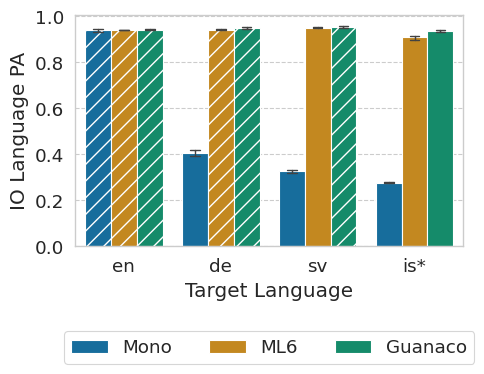

In [69]:
# plot bar plots of lang_match
def make_basic_barplot_long(df, title=None, save_path=None):
    
    # Get the unique values for 'test_set' and 'model_name'
    test_sets = [l for l in ordered_alpaca_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()

    # number of bars to plot with hue
    expected_num_bars = len(test_sets) * len(model_names)

    fig, ax = plt.subplots(figsize=(4, expected_num_bars//4))

    sns.barplot(data=df,
                x='lang_match', y='test_set', 
                hue='model_name', 
                errorbar=("ci", 95), capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                orient='h',
                ax=ax)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    sorted_bars = sorted(bars, key=lambda bar: bar.get_y(), reverse=False)
    
    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
    #         # The index of the bar in the patches list
            index = i * len(model_names) + j
            bar_info[sorted_bars[index]] = {'test_set': test_set, 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'][:2] in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch('//')
        else:
            bar.set_hatch('')

    if title:
        ax.set_title(title)

    ax.set_xlabel('Language Match')
    ax.set_ylabel('Target Language')

    # add vertical gridlines
    ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.4)

    # legend at bottom
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'{save_path} saved.')

    return

def make_basic_barplot_wide(df, title=None, save_path=None):
    
    # Get the unique values for 'test_set' and 'model_name'
    test_sets = [l for l in ordered_alpaca_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()

    # number of bars to plot with hue
    expected_num_bars = len(test_sets) * len(model_names)

    width = len(test_sets)
    if len(test_sets) < 6:
        width += 1

    fig, ax = plt.subplots(figsize=(width, 3))

    sns.barplot(data=df,
                x='test_set', y='lang_match', 
                hue='model_name', 
                errorbar=("ci", 95), capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                ax=ax)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
    #         # The index of the bar in the patches list
            index = i * len(model_names) + j
            # only add the first two letters of the test set to capture e.g. sv
            bar_info[sorted_bars[index]] = {'test_set': test_set[:2], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch('//')
        else:
            bar.set_hatch('')

    if title:
        ax.set_title(title)

    ax.set_xlabel('Target Language')
    ax.set_ylabel('IO Language PA')

    # add horizontal gridlines
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.4)

    # legend at bottom
    if len(test_sets) >= 6:
        ncols = len(model_names)
        y_offset = -0.45
    else:
        ncols = 3
        y_offset = -0.55
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'{save_path} saved.')

    return

# # plot Llama-2 models with incremental multilingual training
# sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 ML2', 'Llama-2 ML3', 'Llama-2 ML4', 'Llama-2 ML5', 'Llama-2 ML6/ca', 'Llama-2 Guanaco'])]
# sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# # sdf = sdf[sdf['test_set'].isin(['sv', 'da', 'no', 'bg', 'is', 'hi', 'el'])]
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '')

# make_basic_barplot_wide(
#     sdf, 
#     # title='IO Language Agreement (avg. 3 inference runs with 95% CI)', 
#     save_path='data/plots/chat_llama2_7b_lang_match_incremental_ml_wide.png')

# # plot Llama-2 models with incremental MT multilingual training
# sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 MT ML2', 'Llama-2 MT ML3', 'Llama-2 MT ML4', 'Llama-2 MT ML5', 'Llama-2 MT ML6'])]
# sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')

# make_basic_barplot_wide(
#     sdf, 
#     # title='IO Language Agreement (avg. 3 inference runs with 95% CI)', 
#     save_path='data/plots/chat_llama2_7b_lang_match_incremental_mt_ml_wide.png')

# # plot Llama-2 70B models with incremental mt multilingual training
# sdf = df[df['model_name'].isin(['Llama-2 70B Mono', 'Llama-2 70B MT ML2', 'Llama-2 70B MT ML3', 'Llama-2 70B MT ML4', 'Llama-2 70B MT ML5', 'Llama-2 70B MT ML6'])]
# sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 70B ', '')
# make_basic_barplot_wide(
#     sdf, 
#     # title='IO Language Agreement (avg. 3 inference runs with 95% CI)', 
#     save_path='data/plots/chat_llama2_70b_lang_match_incremental_mt_ml_wide.png'
#     )

# get only Llama-2 models with incremental multilingual training
# en, es, ru, de, zh, fr
# sdf = df[df['model_name'].isin(['Llama-2 ML6/es', 'Llama-2 ML6/ru', 'Llama-2 ML6/de', 'Llama-2 ML6/zh', 'Llama-2 ML6/fr', 'Llama-2 ML6/ca'])]
# # sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# sdf = sdf[sdf['test_set'].isin(['es', 'ru', 'de', 'zh', 'fr', 'ca'])]
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')
# make_basic_barplot_wide(
#     sdf, 
#     # title='IO Language Agreement (avg. 3 inference runs with 95% CI)', 
#     save_path='data/plots/chat_llama2_7b_lang_match_loo_wide.png')

# plot Llama-2 models with incremental multilingual training
sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 ML6/ca', 'Llama-2 Guanaco'])]
sdf = sdf[sdf['test_set'].isin(['en', 'de', 'sv', 'is*'])]

# sdf = sdf[sdf['test_set'].isin(['sv', 'da', 'no', 'bg', 'is', 'hi', 'el'])]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '')

make_basic_barplot_wide(
    sdf, 
    # title='IO Language Agreement (avg. 3 inference runs with 95% CI)', 
    save_path='data/plots/chat_lang_match_llama2_7b_mono_vs_guanaco.png')


data/plots/chat_lang_match_heatmap_llama2_7b_loo.png saved.
data/plots/chat_lang_match_heatmap_llama2_7b_incremental.png saved.
data/plots/chat_lang_match_heatmap_llama2_7b_mono_vs_guanaco.png saved.
data/plots/chat_lang_match_heatmap_falcon_loo.png saved.
data/plots/chat_lang_match_heatmap_falcon_incremental.png saved.


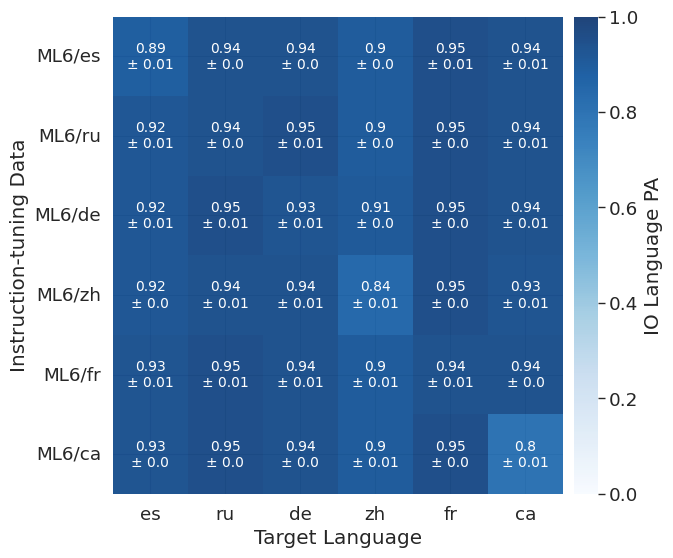

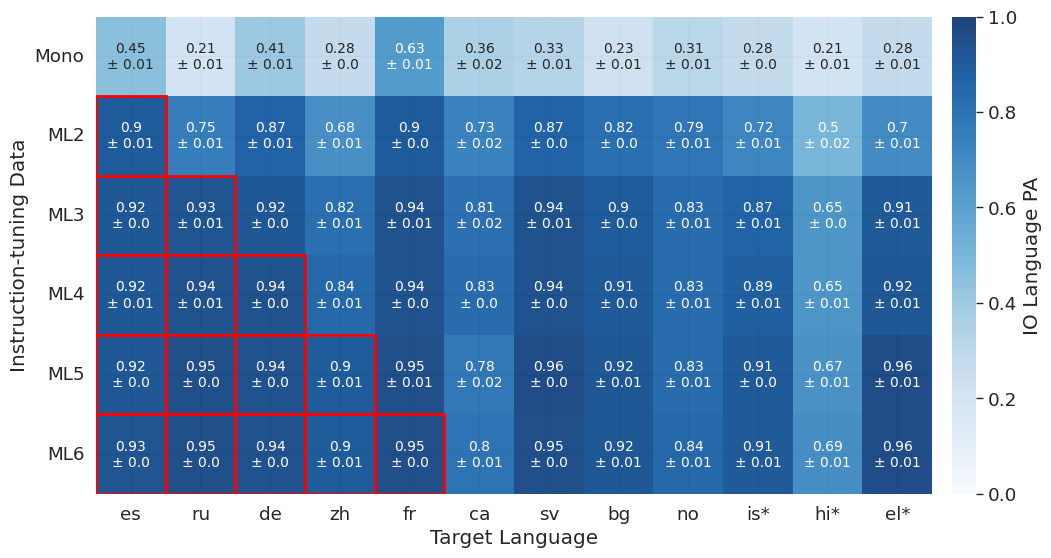

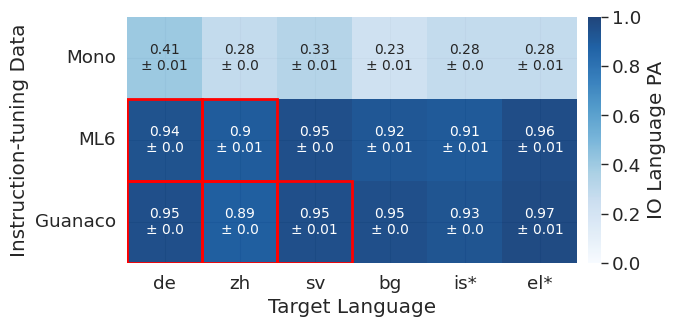

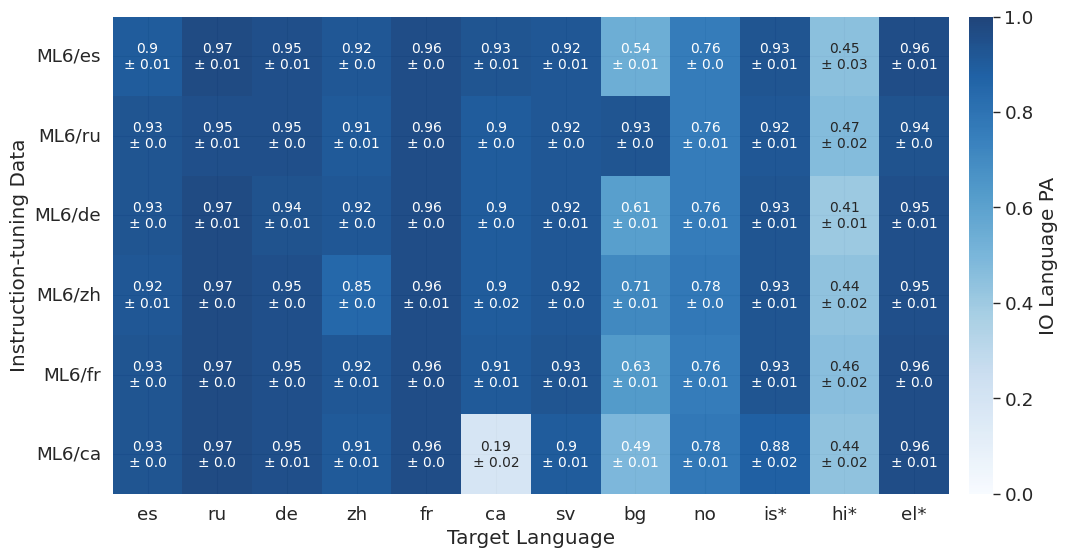

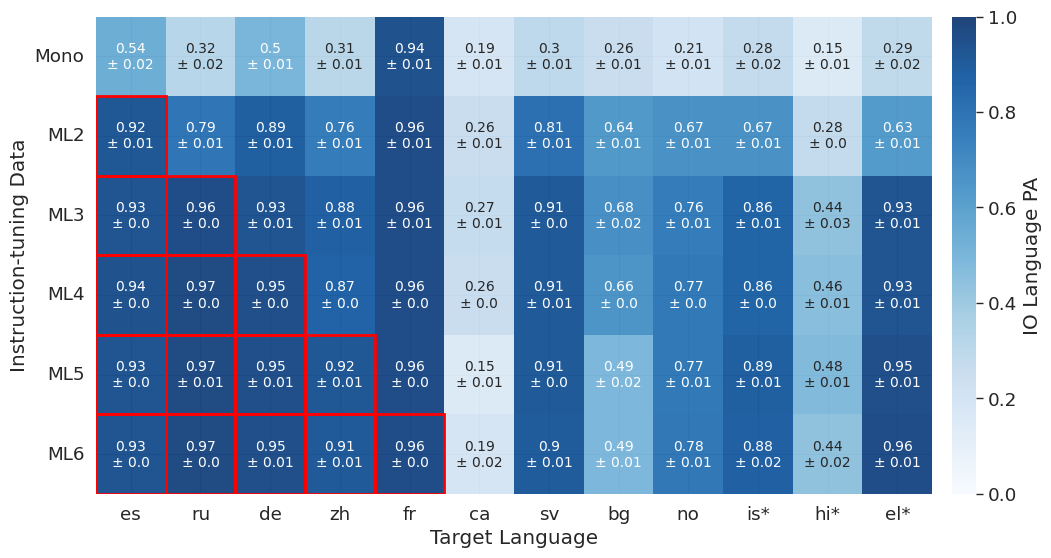

In [70]:
from matplotlib.patches import Rectangle

def make_basic_heatmap(df, metric, include_std=False, title=None, save_path=None, strip_from_model_name=None, include_hatches=False):
        
    models = df['model_name'].unique()
    test_sets = df['test_set'].unique()

    # fig, ax = plt.subplots(figsize=(df.shape[0]*0.2, df.shape[1]*0.8))
    fig, ax = plt.subplots(figsize=(len(test_sets)+1, len(models)+0.2))
    
    heatmap_mean = df.pivot_table(index='model_name', columns='test_set', values=f'{metric}_mean', sort=False)
    heatmap_std = df.pivot_table(index='model_name', columns='test_set', values=f'{metric}_std', sort=False)

    # sort by order in name_map
    heatmap_mean = heatmap_mean.reindex([n for n in ordered_model_names if n in heatmap_mean.index])
    heatmap_std = heatmap_std.reindex([n for n in ordered_model_names if n in heatmap_std.index])

    # sort columns by order in ordered_test_sets
    heatmap_mean = heatmap_mean.reindex(columns=[l for l in ordered_alpaca_test_sets if l in heatmap_mean.columns])
    heatmap_std = heatmap_std.reindex(columns=[l for l in ordered_alpaca_test_sets if l in heatmap_std.columns])

    if strip_from_model_name is not None:
        for segment in strip_from_model_name:
            heatmap_mean.index = heatmap_mean.index.str.replace(segment, '')
            heatmap_std.index = heatmap_std.index.str.replace(segment, '')

    if include_std:
        annotations = heatmap_mean.round(2).astype(str) + "\n± " + heatmap_std.round(2).astype(str)
    else:
        annotations = heatmap_std.round(2).astype(str)

    ax = sns.heatmap(
        heatmap_mean, annot=annotations, fmt='', 
        cmap='Blues', alpha=0.9, cbar=True, 
        cbar_kws={'label': f'IO Language PA', 
                #   'orientation': 'horizontal', 
                  'pad': 0.02,
                  }, 
        vmin=0, vmax=1.0, ax=ax
        )


    highlight_color = 'red'
    if include_hatches:
        # Get the x and y axis labels
        x_labels = heatmap_mean.columns.values
        y_labels = heatmap_mean.index.values

        # Iterate over the cells based on some condition
        for y in range(heatmap_mean.shape[0]):  # for each row
            for x in range(heatmap_mean.shape[1]):  # for each column
                # Check if the cell meets your condition to have hatches
                # Replace 'your_condition' with the actual condition
                if x_labels[x].strip('*') in training_langs[y_labels[y].split()[-1]]:
                    # Add a rectangle with the desired hatch pattern
                    # ax.add_patch(Rectangle((x, y), 1, 1, fill=False, hatch='O.', snap=False))
                    ax.add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor=highlight_color, lw=2))

        
    # reduce font size of annotations
    for t in ax.texts:
        t.set_fontsize(10)
    
    if title:
        ax.set_title(title)

    ax.set_ylabel('Instruction-tuning Data')
    ax.set_xlabel('Target Language')

    # ensure yaxis labels are horizontal
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'{save_path} saved.')

    return

sdf = df[df['model_name'].isin(['Llama-2 ML6/es', 'Llama-2 ML6/ru', 'Llama-2 ML6/de', 'Llama-2 ML6/zh', 'Llama-2 ML6/fr', 'Llama-2 ML6/ca'])]
sdf = sdf[sdf['test_set'].isin(['es', 'de', 'fr', 'ca', 'zh', 'ru'])]

# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    # title='IO Language PA', 
    save_path='data/plots/chat_lang_match_heatmap_llama2_7b_loo.png',
    strip_from_model_name=['Llama-2 ']
    )

sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 ML2', 'Llama-2 ML3', 'Llama-2 ML4', 'Llama-2 ML5', 'Llama-2 ML6/ca'])]
sdf = sdf[sdf['test_set'].isin(['es', 'de', 'fr', 'ca', 'zh', 'ru', 'sv', 'no', 'bg', 'is*', 'hi*', 'el*'])]
# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='', 
    save_path='data/plots/chat_lang_match_heatmap_llama2_7b_incremental.png',
    strip_from_model_name=['Llama-2 ', '/ca'],
    include_hatches=True
    )

sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 ML6/ca', 'Llama-2 Guanaco'])]
sdf = sdf[sdf['test_set'].isin(['de', 'zh', 'sv', 'bg', 'is*', 'el*',])]
# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='', 
    save_path='data/plots/chat_lang_match_heatmap_llama2_7b_mono_vs_guanaco.png',
    strip_from_model_name=['Llama-2 ', '/ca'],
    include_hatches=True
    )

sdf = df[df['model_name'].isin(['Falcon ML6/de', 'Falcon ML6/zh', 'Falcon ML6/ru', 'Falcon ML6/ca', 'Falcon ML6/es', 'Falcon ML6/fr'])]
sdf = sdf[sdf['test_set'].isin(['es', 'de', 'fr', 'ca', 'zh', 'ru', 'sv', 'no', 'bg', 'is*', 'hi*', 'el*'])]

# sdf = sdf[sdf['test_set'].isin([ordered_test_sets])]
# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='', 
    save_path='data/plots/chat_lang_match_heatmap_falcon_loo.png',
    strip_from_model_name=['Falcon ']
    )

sdf = df[df['model_name'].isin(['Falcon Mono', 'Falcon ML2', 'Falcon ML3', 'Falcon ML4', 'Falcon ML5', 'Falcon ML6/ca'])]
sdf = sdf[sdf['test_set'].isin(['es', 'de', 'fr', 'ca', 'zh', 'ru', 'sv', 'no', 'bg', 'is*', 'hi*', 'el*'])]
# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='', 
    save_path='data/plots/chat_lang_match_heatmap_falcon_incremental.png',
    strip_from_model_name=['Falcon ', '/ca'],
    include_hatches=True
    )

# process lm-eval harness results

In [71]:
def load_lm_eval_results_file(file):
    with open(file, "r", encoding='utf8') as f:
        df = pd.DataFrame.from_dict(json.load(f)['results'])
        df['model_name'] = Path(file).stem
        return df

def get_lm_eval_results(results_dir):
    dfs = []
    for results_file in Path(results_dir).glob('*.json'):
        print(results_file)
        df = load_lm_eval_results_file(results_file)
        dfs.append(df)
    df = pd.concat(dfs, axis=0, ignore_index=False).reset_index()
    df = df.rename(columns={'index': 'metric'})

    # Reshape the dataframe, moving model_name and index to the index
    df_long = pd.melt(df, id_vars=['model_name', 'metric'], var_name='task_lang', value_name='score')

    # Split the task_lang into two separate columns for 'task' and 'lang'
    df_long[['task', 'lang']] = df_long['task_lang'].str.split('_', expand=True)

    # Drop the original task_lang column as it's no longer needed
    df_long.drop('task_lang', axis=1, inplace=True)

    # Now pivot to get the 'task', 'lang' and 'index' as part of the column MultiIndex
    df = df_long.pivot_table(index='model_name', columns=['task', 'lang', 'metric'], values='score')

    # # move model_name to front
    # cols = df.columns.tolist()
    # cols.insert(0, cols.pop(cols.index('model_name')))
    # df = df.reindex(columns=cols)
    
    # # split task and lang tags into multiple levels

    # df.set_index(['model_name', 'metric'], inplace=True)
    # df = df.unstack(level='metric')
    
    df.info()

    return df

df = get_lm_eval_results('data/lm_evals')
df

data/lm_evals/llama_2_7b_hf_zh_merged.json
data/lm_evals/llama_2_7b_hf_de_merged.json
data/lm_evals/llama_2_7b_hf_fr_merged.json
data/lm_evals/llama_2_7b_hf_es_merged.json
data/lm_evals/llama_2_7b_hf_ca_merged.json
data/lm_evals/llama_2_7b_hf_ru_merged.json
data/lm_evals/llama_2_7b_hf_ml1_merged.json
data/lm_evals/llama_2_7b_hf_mt_ml2_merged.json
data/lm_evals/llama_2_7b_hf_ml2_merged.json
data/lm_evals/llama_2_7b_hf_mt_ml3_merged.json
data/lm_evals/llama_2_7b_hf_ml3_merged.json
data/lm_evals/llama_2_7b_hf_mt_ml4_merged.json
data/lm_evals/llama_2_7b_hf_ml4_merged.json
data/lm_evals/llama_2_7b_hf_mt_ml5_merged.json
data/lm_evals/llama_2_7b_hf_ml5_merged.json
data/lm_evals/llama_2_7b_hf_mt_ml6_merged.json
data/lm_evals/Llama-2-7b-hf.json
data/lm_evals/llama_2_7b_hf_guanaco_merged.json
data/lm_evals/llama_2_70b_hf_mt_ml1_merged.json
data/lm_evals/llama_2_70b_hf_mt_ml2_merged.json
data/lm_evals/llama_2_70b_hf_mt_ml3_merged.json
data/lm_evals/llama_2_70b_hf_mt_ml5_merged.json
data/lm_evals/

task                           pawsx                                        \
lang                              de                 en                 es   
metric                           acc acc_stderr     acc acc_stderr     acc   
model_name                                                                   
Llama-2-7b-hf                 0.6375   0.010752  0.6860   0.010381  0.6510   
llama_2_70b_hf_mt_ml1_merged  0.6595   0.010599  0.6680   0.010533  0.6395   
llama_2_70b_hf_mt_ml2_merged  0.6685   0.010529  0.6680   0.010533  0.6295   
llama_2_70b_hf_mt_ml3_merged  0.6570   0.010618  0.6820   0.010416  0.6415   
llama_2_70b_hf_mt_ml4_merged  0.6455   0.010699  0.6670   0.010541  0.6380   
llama_2_70b_hf_mt_ml5_merged  0.6350   0.010768  0.6855   0.010385  0.6470   
llama_2_70b_hf_mt_ml6_merged  0.6430   0.010716  0.6760   0.010467  0.6430   
llama_2_7b_hf_ca_merged       0.6485   0.010679  0.6955   0.010293  0.6710   
llama_2_7b_hf_de_merged       0.6465   0.010692  0.6970   0.010279  0.6775   
llama_2_7b_hf_es_merged       0.6480   0.010682  0.6965   0.010283  0.6745   
llama_2_7b_hf_fr_merged       0.6505   0.010665  0.6980   0.010269  0.6735   
llama_2_7b_hf_guanaco_merged  0.6560   0.010625  0.6950   0.010298  0.6750   
llama_2_7b_hf_ml1_merged      0.6430   0.010716  0.6935   0.010312  0.6680   
llama_2_7b_hf_ml2_merged      0.6450   0.010703  0.6950   0.010298  0.6715   
llama_2_7b_hf_ml3_merged      0.6480   0.010682  0.6930   0.010316  0.6710   
llama_2_7b_hf_ml4_merged      0.6490   0.010675  0.6945   0.010302  0.6725   
llama_2_7b_hf_ml5_merged      0.6475   0.010685  0.6955   0.010293  0.6725   
llama_2_7b_hf_mt_ml2_merged   0.6510   0.010661  0.6925   0.010321  0.6770   
llama_2_7b_hf_mt_ml3_merged   0.6555   0.010629  0.6900   0.010344  0.6810   
llama_2_7b_hf_mt_ml4_merged   0.6555   0.010629  0.6915   0.010330  0.6775   
llama_2_7b_hf_mt_ml5_merged   0.6590   0.010603  0.6925   0.010321  0.6750   
llama_2_7b_hf_mt_ml6_merged   0.6610   0.010588  0.6925   0.010321  0.6805   
llama_2_7b_hf_ru_merged       0.6540   0.010639  0.6970   0.010279  0.6740   
llama_2_7b_hf_zh_merged       0.6525   0.010650  0.6965   0.010283  0.6775   

task                                                                           \
lang                                         fr                 ja              
metric                       acc_stderr     acc acc_stderr     acc acc_stderr   
model_name                                                                      
Llama-2-7b-hf                  0.010661  0.5855   0.011018  0.4995   0.011183   
llama_2_70b_hf_mt_ml1_merged   0.010739  0.5810   0.011035  0.5545   0.011117   
llama_2_70b_hf_mt_ml2_merged   0.010802  0.5825   0.011030  0.5475   0.011133   
llama_2_70b_hf_mt_ml3_merged   0.010726  0.5740   0.011060  0.5510   0.011125   
llama_2_70b_hf_mt_ml4_merged   0.010749  0.5855   0.011018  0.5680   0.011079   
llama_2_70b_hf_mt_ml5_merged   0.010689  0.5815   0.011034  0.5395   0.011148   
llama_2_70b_hf_mt_ml6_merged   0.010716  0.5890   0.011005  0.5490   0.011129   
llama_2_7b_hf_ca_merged        0.010509  0.6040   0.010939  0.4995   0.011183   
llama_2_7b_hf_de_merged        0.010455  0.6045   0.010936  0.5025   0.011183   
llama_2_7b_hf_es_merged        0.010480  0.6020   0.010948  0.4980   0.011183   
llama_2_7b_hf_fr_merged        0.010488  0.6040   0.010939  0.4995   0.011183   
llama_2_7b_hf_guanaco_merged   0.010476  0.6000   0.010957  0.4920   0.011182   
llama_2_7b_hf_ml1_merged       0.010533  0.6040   0.010939  0.4975   0.011183   
llama_2_7b_hf_ml2_merged       0.010505  0.6045   0.010936  0.4980   0.011183   
llama_2_7b_hf_ml3_merged       0.010509  0.6060   0.010929  0.4970   0.011183   
llama_2_7b_hf_ml4_merged       0.010497  0.6005   0.010955  0.4945   0.011182   
llama_2_7b_hf_ml5_merged       0.010497  0.6060   0.010929  0.4945   0.011182   
llama_2_7b_hf_mt_ml2_merged    0.010459  0.6165   0.010875  0.4925   0.011182   
llama_2_7b_hf_mt_ml3_merged    0.

In [72]:
def process_single_dataset_df(df):

    # multiply all numeric values by 100
    df[df.select_dtypes(include=['number']).columns] *= 100
    # round all numeric values to 2 decimal places
    df = df.round(2)

    # get the list of langs in dataframe from the multi-index
    langs = df.columns.get_level_values(0).unique().tolist()
    
    for lang in langs:
        acc_col = (lang, 'acc')
        stderr_col = (lang, 'acc_stderr') 
        df[lang] = df[acc_col].astype(str) + ' ± ' + df[stderr_col].astype(str)

    # drop all acc_stderr columns from multi-index
    df.drop(df.filter(like='acc_stderr').columns, axis=1, inplace=True)

    # drop 'metric' level from multi-index
    df.columns = df.columns.droplevel(level=1)

    # drop model_name as index
    df.reset_index(inplace=True)

    df.replace({'model_name': name_map}, inplace=True)

    print(df['model_name'].unique())

    # # sort rows by model_name in name_map
    df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)
    df = df.sort_values(by=['model_name'])
    # # Convert the columns back to their original data types
    df['model_name'] = df['model_name'].astype(str)
    
    # subscript the stderror values in each cell
    # df = df.style.format(lambda x: x.replace('±', '\pm '))

    return df
print('\nPAWS-X\n')
print(process_single_dataset_df(df['pawsx']).to_latex(index=False))
print('\nXNLI\n')
print(process_single_dataset_df(df['xnli']).to_latex(index=False))
print('\nX-Winograd\n')
print(process_single_dataset_df(df['xwinograd']).to_latex(index=False))



PAWS-X

['Llama-2 (base)' 'Llama-2 70B Mono' 'Llama-2 70B MT ML2'
 'Llama-2 70B MT ML3' 'Llama-2 70B MT ML4' 'Llama-2 70B MT ML5'
 'Llama-2 70B MT ML6' 'Llama-2 ML6/ca' 'Llama-2 ML6/de' 'Llama-2 ML6/es'
 'Llama-2 ML6/fr' 'Llama-2 Guanaco' 'Llama-2 Mono' 'Llama-2 ML2'
 'Llama-2 ML3' 'Llama-2 ML4' 'Llama-2 ML5' 'Llama-2 MT ML2'
 'Llama-2 MT ML3' 'Llama-2 MT ML4' 'Llama-2 MT ML5' 'Llama-2 MT ML6'
 'Llama-2 ML6/ru' 'Llama-2 ML6/zh']
\begin{tabular}{llllllll}
\toprule
        model\_name &           de &           en &           es &           fr &           ja &           ko &           zh \\
\midrule
    Llama-2 (base) & 63.75 ± 1.08 &  68.6 ± 1.04 &  65.1 ± 1.07 &  58.55 ± 1.1 & 49.95 ± 1.12 &  52.0 ± 1.12 &  58.05 ± 1.1 \\
      Llama-2 Mono &  64.3 ± 1.07 & 69.35 ± 1.03 &  66.8 ± 1.05 &  60.4 ± 1.09 & 49.75 ± 1.12 & 51.15 ± 1.12 &   59.2 ± 1.1 \\
       Llama-2 ML2 &  64.5 ± 1.07 &  69.5 ± 1.03 & 67.15 ± 1.05 & 60.45 ± 1.09 &  49.8 ± 1.12 & 51.45 ± 1.12 &   58.7 ± 1.1 \\
       Llama-

/tmp/ipykernel_2881943/2999050585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.select_dtypes(include=['number']).columns] *= 100
/tmp/ipykernel_2881943/2999050585.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(process_single_dataset_df(df['pawsx']).to_latex(index=False))
/tmp/ipykernel_2881943/2999050585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [73]:
# def plot_single_dataset_df(df):

#     # get the list of langs in dataframe from the multi-index
#     langs = df.columns.get_level_values(0).unique().tolist()

#     print(langs)

#     fig, ax = plt.subplots(figsize=(len(langs), 3))

#     sns.barplot(data=df,
#                 x='lang', 
#                 y='metric', 
#                 hue='model_name', 
#                 errorbar=("ci", 95), capsize=0.3,
#                 err_kws={"linewidth": 1.0},
#                 alpha=1.0,
#                 # hue_order=ordered_test_sets,
#                 ax=ax)

#     # for lang in langs:
#     #     acc_col = (lang, 'acc')
#     #     stderr_col = (lang, 'acc_stderr') 
#     #     df[lang] = df[acc_col].astype(str) + ' ± ' + df[stderr_col].astype(str)

#     # # drop 'metric' level from multi-index
#     # df.columns = df.columns.droplevel(level=1)

#     # # drop model_name as index
#     # df.reset_index(inplace=True)

#     # df.replace({'model_name': name_map}, inplace=True)

#     # print(df['model_name'].unique())

#     # # # sort rows by model_name in name_map
#     # df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)
#     # df = df.sort_values(by=['model_name'])
#     # # # Convert the columns back to their original data types
#     # df['model_name'] = df['model_name'].astype(str)
    
#     # # subscript the stderror values in each cell
#     # # df = df.style.format(lambda x: x.replace('±', '\pm '))

#     return

# # print(plot_single_dataset_df(df['pawsx'].unstack(level=0).reset_index()))
# df_pawsx = df['pawsx'].unstack(level=0).reset_index()
# df_pawsx['index'] = df_pawsx.index
# df_pawsx.pivot(index='index', columns='metric', values=['metric', 'model_name', 0, 'lang'])
# df_pawsx
# # df_pawsx.to_csv('scratch/pawsx.csv', index=True)
# split 'metric' into two columns for 'acc' and 'acc_stderr'


# LLM Judge Results

In [74]:
def get_llm_judge_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for llm_eval_file in sorted(Path(results_dir).glob('*/*.jsonl')):
        # print(llm_eval_file)
        df = pd.read_json(llm_eval_file, lines=True)

        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(llm_eval_file)
        
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        df['n_eval_items'] = n_eval_items
        df['data_seed'] = data_seed
        df['api_seed'] = api_seed
        df['eval_src'] = eval_src
        df['eval_tgt'] = eval_tgt

        dfs.append(df)
            
    print(f'Gathered {len(dfs)} dataframes.')
    df = pd.concat(dfs, axis=0, ignore_index=False, join='outer').reset_index(drop=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('eval_src')))
    cols.insert(4, cols.pop(cols.index('eval_tgt')))
    print(cols)
    df = df.reindex(columns=cols)

    return df

df = get_llm_judge_results('data/llm_evals/likert/gpt-3.5-turbo-1106')
print(len(df))

# inspect rows with NaN values in eval_score
# df[df['eval_score'].isna()]
# df[df['eval_score'] == 0]

# drop rows containing isna values in eval_score
df = df.dropna(subset=['eval_score'])
print(len(df))

# drop rows where eval_score is not between 1 and 6
df = df[(df['eval_score'] >= 1) & (df['eval_score'] <= 6)]
print(len(df))

# if 'system_lang' does not match 'source_lang', then set 'eval_score' to 1
df.loc[df['system_lang'] != df['source_lang'], 'eval_score'] = 1

# rename values according to name_map
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

# discard column with name "eval_Should I leave him. How do I like it?" - occurs once due to parsing errors from jsonl object returned from llm
# data/llm_evals/likert/gpt-3.5-turbo-1106/llama_2_7b_hf_ca_merged/alpaca_eval_instructions_el-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8-with_en-l300-ds42-as42-source_en-system_en.jsonl
df = df.drop(columns=['eval_Should I leave him. How do I like it?'])

df = apply_sort(df, ordered_test_sets=ordered_alpaca_test_sets)

# inspect total tokens from eval_meta
eval_costs = []
for i, row in df.iterrows():
    # eval_tokens.append(row['eval_meta']['prompt_tokens'] + row['eval_meta']['completion_tokens'])
    cost = row['eval_meta']['cost']
    if isinstance(row['translation_meta'], dict):
        cost += row['translation_meta']['cost']
    eval_costs.append(cost)

print(len(df))
print(len(eval_costs))
print(np.mean(eval_costs))
print(max(eval_costs))
print(min(eval_costs))
print(sum(eval_costs))

# drop columns: eval_meta, translation_meta, prompt, source, system
df = df.drop(columns=['eval_meta', 'translation_meta', 'prompt', 'source', 'system', 'source_en', 'system_en', 'eval_reasoning'])
len(df)

# check that for each model, the same ids are evaluated
all_ids = set()
for model_name in df['model_name'].unique():
    ids = df[df['model_name'] == model_name]['id'].unique()
    all_ids.update(ids)
print(len(all_ids))

df.info()

Gathered 1095 dataframes.
['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt', 'prompt', 'system', 'finish_reason', 'source', 'secs', 'source_lang', 'system_lang', 'id', 'eval_reasoning', 'eval_score', 'eval_meta', 'context', 'n_eval_items', 'data_seed', 'api_seed', 'eval_Pizzeria,', 'source_en', 'system_en', 'translation_meta', 'eval_Should I leave him. How do I like it?']
328500
328404
328138
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328138 entries, 0 to 328137
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   model_name        328138 non-null  object 
 1   test_set          328138 non-null  object 
 2   seed              328138 non-null  int64  
 3   eval_src          328138 non-null  object 
 4   eval_tgt          328138 non-null  object 
 5   prompt            328138 non-null  object 
 6   system            328138 non-null  object 
 7   finish_reason     328138 non-null  object 
 8   

In [75]:
# # aggregate score by model_name, test_set, seed
# agg_df = df[df['eval_src'] == 'source'].groupby(['model_name', 'test_set'], as_index=False).agg({'eval_score': [np.mean, np.std]})
# agg_df

# # aggregate score by model_name, test_set, seed
# agg_df = df[df['eval_src'] == 'source_en'].groupby(['model_name', 'test_set'], as_index=False).agg({'eval_score': [np.mean, np.std]})
# agg_df


In [76]:
print(df['model_name'].value_counts())
print(df['eval_src'].value_counts())
print(df['eval_tgt'].value_counts())
print(df['eval_score'].value_counts())
print(df['test_set'].value_counts())
print(df['id'].value_counts())

Llama-2 ML6/ca         22472
Llama-2 Guanaco        11697
Falcon Guanaco         11696
Llama-2 ML5            11694
Falcon ML6/ca          11692
Llama-2 MT ML6         11691
Llama-2 MT ML3         11690
Falcon ML5             11690
Falcon Mono            11689
Llama-2 MT ML5         11689
Llama-2 MT ML2         11689
Llama-2 70B Mono       11688
Llama-2 ML2            11688
Llama-2 Mono           11688
Llama-2 ML3            11687
Llama-2 70B MT ML4     11685
Llama-2 70B MT ML3     11685
Llama-2 ML4            11685
Llama-2 MT ML4         11684
Llama-2 70B MT ML5     11684
Falcon ML2             11684
Falcon ML3             11682
Falcon ML4             11679
Llama-2 70B MT ML2     11676
Llama-2 70B MT ML6     11674
Llama-2 70B Guanaco     9891
Llama-2 MTOL ML6/ca     3596
Llama-2 ML6/de          2699
Llama-2 ML6/zh          2699
Llama-2 ML6/ru          2697
Llama-2 ML6/es          1800
Llama-2 ML6/fr          1798
Name: model_name, dtype: int64
source       312858
source_en     15280
N

In [77]:
df.head()

,model_name,test_set,seed,eval_src,eval_tgt,finish_reason,secs,source_lang,system_lang,id,eval_score,context,n_eval_items,data_seed,api_seed,"eval_Pizzeria,"
0,Llama-2 Mono,en,0,source,system,stop,0.793132,eng_Latn,eng_Latn,192,5.0,guanaco_prompt,300,42,42,NaN
1,Llama-2 Mono,en,0,source,system,stop,1.108659,eng_Latn,eng_Latn,718,6.0,guanaco_prompt,300,42,42,NaN
2,Llama-2 Mono,en,0,source,system,stop,2.605155,eng_Latn,eng_Latn,168,3.0,guanaco_prompt,300,42,42,NaN
3,Llama-2 Mono,en,0,source,system,stop,1.376305,eng_Latn,eng_Latn,522,4.0,guanaco_prompt,300,42,42,NaN
4,Llama-2 Mono,en,0,source,system,stop,0.841068,eng_Latn,eng_Latn,536,5.0,guanaco_prompt,300,42,42,NaN


In [78]:
# set pandas settings to display more rows
pd.set_option('display.max_rows', 50)
df['model_name'].value_counts()

Llama-2 ML6/ca         22472
Llama-2 Guanaco        11697
Falcon Guanaco         11696
Llama-2 ML5            11694
Falcon ML6/ca          11692
Llama-2 MT ML6         11691
Llama-2 MT ML3         11690
Falcon ML5             11690
Falcon Mono            11689
Llama-2 MT ML5         11689
Llama-2 MT ML2         11689
Llama-2 70B Mono       11688
Llama-2 ML2            11688
Llama-2 Mono           11688
Llama-2 ML3            11687
Llama-2 70B MT ML4     11685
Llama-2 70B MT ML3     11685
Llama-2 ML4            11685
Llama-2 MT ML4         11684
Llama-2 70B MT ML5     11684
Falcon ML2             11684
Falcon ML3             11682
Falcon ML4             11679
Llama-2 70B MT ML2     11676
Llama-2 70B MT ML6     11674
Llama-2 70B Guanaco     9891
Llama-2 MTOL ML6/ca     3596
Llama-2 ML6/de          2699
Llama-2 ML6/zh          2699
Llama-2 ML6/ru          2697
Llama-2 ML6/es          1800
Llama-2 ML6/fr          1798
Name: model_name, dtype: int64

['Mono' 'ML2' 'ML3' 'ML4' 'ML5' 'ML6' 'Guanaco']
saved to data/plots/chat_llm_judge_llama_7b_incremental.png


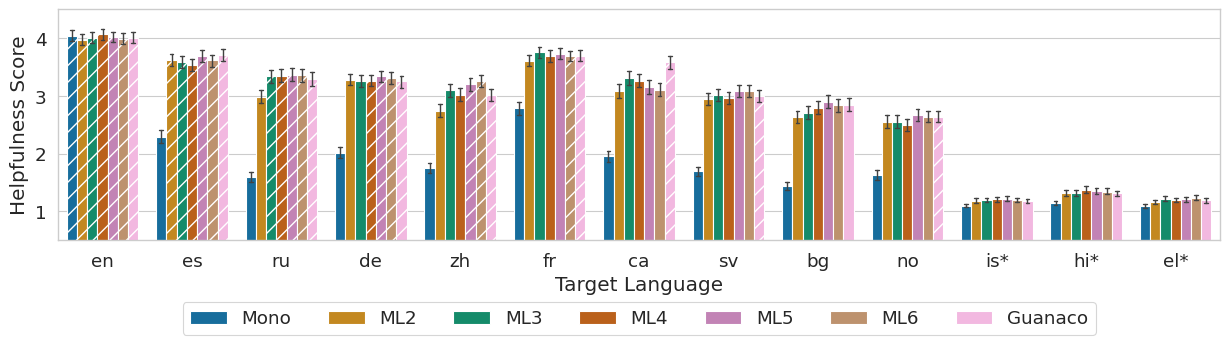

In [79]:

def plot_llm_judge_score_distribution(df, title=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(15, 3))
    
    test_sets = [l for l in ordered_alpaca_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    print(model_names)
    # sns.boxplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    # sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax,  
                errorbar=("ci", 95), capsize=0.3,
                # errorbar='sd', capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                )
        
    # apply hatches to certain bars
    # for p in ax.patches:
    #     print(p)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
            # The index of the bar in the patches list
            index = i * len(model_names) + j
            # only add the first two letters of the test set to capture e.g. sv
            bar_info[sorted_bars[index]] = {'test_set': test_set[:2], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch('//')
        else:
            bar.set_hatch('')

    
    
    ax.set_xlabel('Target Language')
    ax.set_ylabel('Helpfulness Score')
    
    # fix ylim to 1-6
    ax.set_ylim(0.5, 4.5)

    ax.set_title(title)

    # legend at bottom
    if len(test_sets) >= 6:
        ncols = len(model_names)
        y_offset = -0.45
    else:
        ncols = 3
        y_offset = -0.55
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return


sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 ML2', 'Llama-2 ML3', 'Llama-2 ML4', 'Llama-2 ML5', 'Llama-2 ML6/ca', 'Llama-2 Guanaco'])]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '')

plot_llm_judge_score_distribution(
    sdf, 
    # title='Llama-7b Evaluation (evaluated in x)',
    save_path='data/plots/chat_llm_judge_llama_7b_incremental.png'
    )



# sdf = df[df['model_name'].isin(['Llama-2 ML6/es', 'Llama-2 ML6/ru', 'Llama-2 ML6/de', 'Llama-2 ML6/zh', 'Llama-2 ML6/fr', 'Llama-2 ML6/ca'])]
# sdf = sdf[sdf['test_set'].isin(['es', 'ru', 'de', 'zh', 'fr', 'ca'])]
# sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')

# plot_llm_judge_score_distribution(
#     sdf, 
#     # title='Llama-7b Evaluation (evaluated in x)',
#     save_path='data/plots/chat_llm_judge_llama_7b_loo.png'
#     )

MT ML6    11691
MT ML3    11690
MT ML2    11689
MT ML5    11689
Mono      11688
MT ML4    11684
Name: model_name, dtype: int64
['Mono' 'MT ML2' 'MT ML3' 'MT ML4' 'MT ML5' 'MT ML6']
saved to data/plots/chat_llm_judge_llama_7b_incremental_mt.png


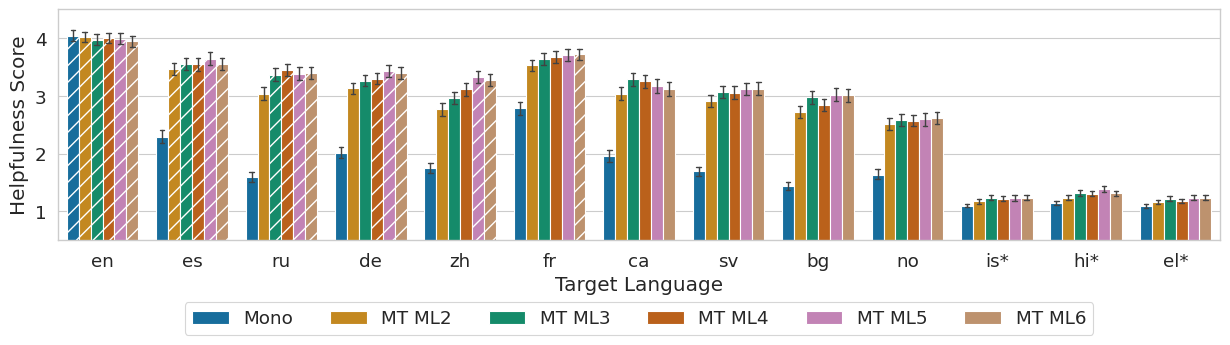

In [80]:
sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 MT ML2', 'Llama-2 MT ML3', 'Llama-2 MT ML4', 'Llama-2 MT ML5', 'Llama-2 MT ML6'])]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2', '').str.strip()
# print(len(sdf))
print(sdf['model_name'].value_counts())
plot_llm_judge_score_distribution(
    sdf, 
    # title='Llama-7b MT ML Evaluation (evaluated in x)',
    save_path='data/plots/chat_llm_judge_llama_7b_incremental_mt.png'
    )


Mono      11688
MT ML3    11685
MT ML4    11685
MT ML5    11684
MT ML2    11676
MT ML6    11674
Name: model_name, dtype: int64
['Mono' 'MT ML2' 'MT ML3' 'MT ML4' 'MT ML5' 'MT ML6']
saved to data/plots/chat_llm_judge_llama_70b_incremental_mt.png


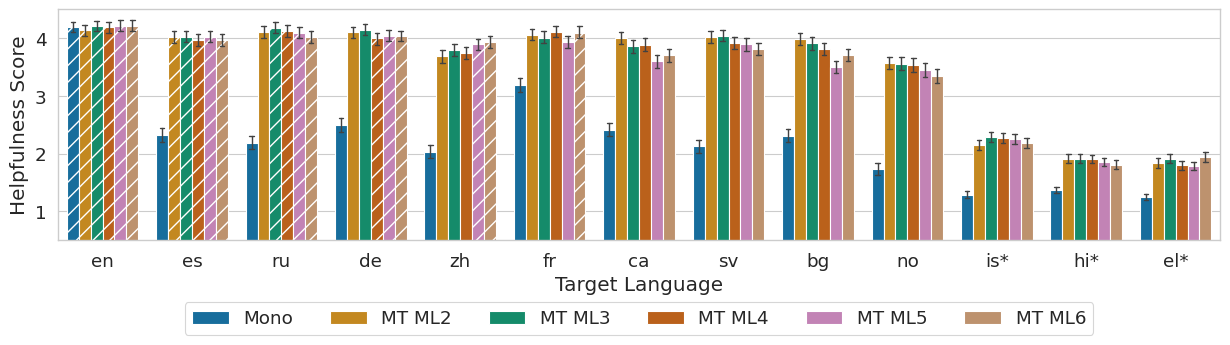

In [81]:
sdf = df[df['model_name'].isin(['Llama-2 70B Mono', 'Llama-2 70B MT ML2', 'Llama-2 70B MT ML3', 'Llama-2 70B MT ML4', 'Llama-2 70B MT ML5', 'Llama-2 70B MT ML6'])]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 70B', '').replace('MT', '').str.strip()
# print(len(sdf))
print(sdf['model_name'].value_counts())
plot_llm_judge_score_distribution(
    sdf, 
    # title='Llama-70b MT ML Evaluation (evaluated in x)',
    save_path='data/plots/chat_llm_judge_llama_70b_incremental_mt.png'
    )


In [82]:
# sdf = df[df['model_name'].isin(['Llama-2 MTOL ML6/ca'])]
# sdf = sdf[sdf['test_set'].isin(ordered_test_sets)]
# # sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
# # sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 70B', '')
# # print(len(sdf))
# print(sdf['model_name'].value_counts())
# plot_score_distribution(
#     sdf, 
#     title='Llama-70b Evaluation (evaluated in x)',
#     save_path='data/plots/llm_judge_7b_incremental_ml_mtol_wide.png'
#     )

81812
Guanaco    11696
ML6        11692
ML5        11690
Mono       11689
ML2        11684
ML3        11682
ML4        11679
Name: model_name, dtype: int64
['Mono' 'ML2' 'ML3' 'ML4' 'ML5' 'ML6' 'Guanaco']
saved to data/plots/chat_llm_judge_falcon_7b_incremental.png


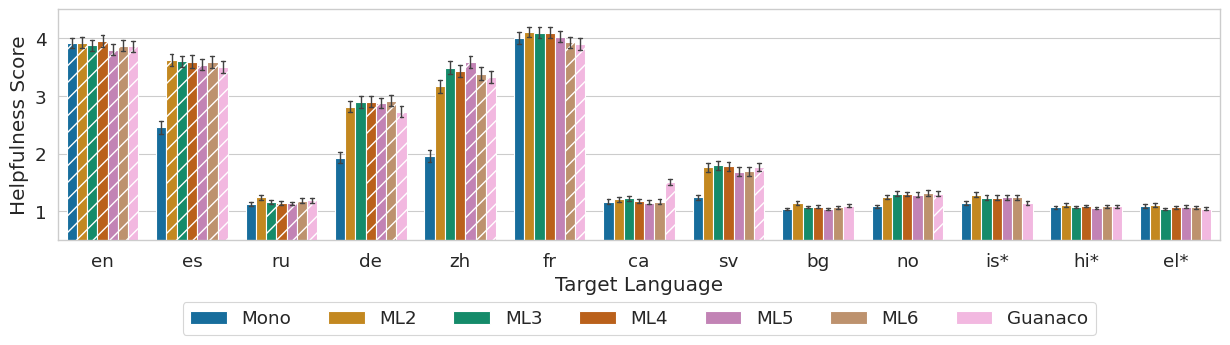

In [83]:
sdf = df[df['model_name'].isin(['Falcon Mono', 'Falcon ML2', 'Falcon ML3', 'Falcon ML4', 'Falcon ML5', 'Falcon ML6/ca', 'Falcon Guanaco'])]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Falcon', '').str.replace('/ca', '').str.strip()
print(len(sdf))
print(sdf['model_name'].value_counts())
plot_llm_judge_score_distribution(
    sdf, 
    # title='Falcon-7b ML Evaluation (evaluated in x)',
    save_path='data/plots/chat_llm_judge_falcon_7b_incremental.png'
    )

In [84]:
# sdf = df[ (df['model_name'].isin([
#     'Llama-2 ML2', 'Llama-2 MT ML2', 
#     'Llama-2 ML3', 'Llama-2 MT ML3', 
#     'Llama-2 ML4', 'Llama-2 MT ML4',
#     'Llama-2 ML5', 'Llama-2 MT ML5'
#     'Llama-2 ML6/ca', 'Llama-2 MT ML6'
#     ])) ]
# sdf = sdf[sdf['test_set'].isin(['de'])]
# print(sdf['model_name'].value_counts())
# print(sdf['test_set'].value_counts())

# plot_score_distribution(
#     sdf, 
#     title='Distribution of scores based on MT ML',
#     # save_path='data/plots/llm_judge_7b_translated_vs_direct_eval.png'
#     )


ca     1800
bg     1800
no     1800
es     1799
zh     1799
el*    1799
de     1798
fr     1798
sv     1798
is*    1798
ru     1796
hi*    1788
en      899
Name: test_set, dtype: int64
saved to data/plots/chat_llm_judge_llama_7b_translated_vs_direct_eval.png


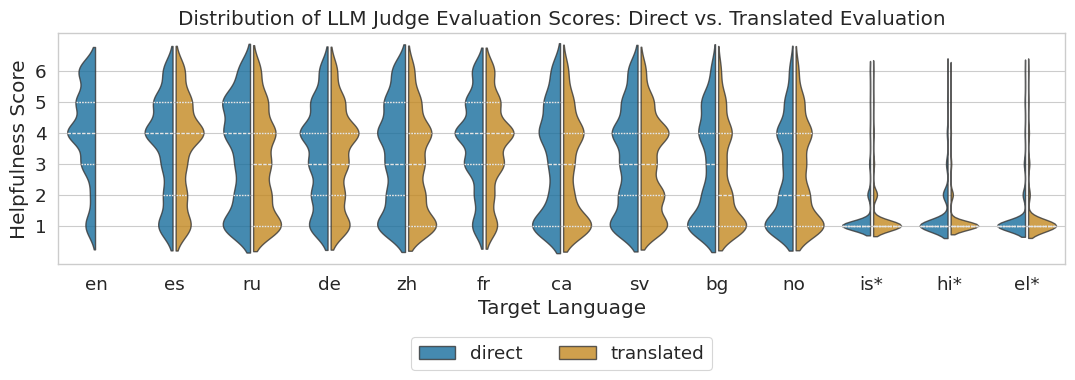

In [85]:

def plot_score_distribution_with_split_violins(df, title=None, save_path=None, hue='eval_type'):

    # for each test set, plot the distribution of eval_score for each model
    
    test_sets = [l for l in ordered_alpaca_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    
    fig, ax = plt.subplots(figsize=(len(test_sets), 3))
    
    sns.violinplot(data=df, x='test_set', y='eval_score', hue=hue, ax=ax, 
                   fill=True, density_norm="count", common_norm=True,
                   split=True,
                   inner="quart",
                   dodge=True, gap=0.1,
                   alpha=0.8,
                   order=test_sets,
                #    inner_kws=dict(box_width=4, whis_width=1, color=".8"),
                   inner_kws=dict(color=".9"),
                   )
    
    ax.set_xlabel('Target Language')
    ax.set_ylabel('Helpfulness Score')
    
    # set y-ticks to integers 1-6
    ax.set_yticks(range(1, 7))

    ax.set_title(title)

    # place legend outside of plot at bottom with 3 columns
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return

sdf = df[ (df['model_name'].isin(['Llama-2 ML6/ca'])) ]
print(sdf['test_set'].value_counts())
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]

sdf['eval_type'] = sdf.apply(lambda x: "translated" if x['eval_src'] == 'source_en' else "direct", axis=1)

plot_score_distribution_with_split_violins(
    sdf, 
    title='Distribution of LLM Judge Evaluation Scores: Direct vs. Translated Evaluation',
    save_path='data/plots/chat_llm_judge_llama_7b_translated_vs_direct_eval.png'
    )

# for seed in [0, 42, 723]:
#     sdf = df[ (df['model_name'].isin(['Llama-2 ML6/ca'])) & (df['seed'] == seed) ] 
#     sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]

#     sdf['eval_type'] = sdf.apply(lambda x: "translated" if x['eval_src'] == 'source_en' else "direct", axis=1)

#     plot_score_distribution_with_split_violins(
#         sdf, 
#         title='Distribution of LLM Judge Evaluation Scores: Direct vs. Translated Evaluation',
#         save_path=f'data/plots/chat_llm_judge_llama_7b_s{seed}_translated_vs_direct_eval.png'
#         )

# translation results

In [86]:
# translation results

# def get_mt_results(results_dir):
#     """
#     Collect all eval files in results_dir and parse them into a dataframe
#     """
#     dfs = []
#     for eval_file in sorted(Path(results_dir).glob('*/*.eval')):
#         # print(eval_file)
#         df = pd.read_csv(eval_file, index_col=None)
#         # print(eval_file)
#         model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(eval_file)
        
#         df['model_name'] = model_name
#         df['test_set'] = test_set
#         df['prompt'] = prompt
#         df['seed'] = seed
#         df['n_eval_items'] = n_eval_items
#         df['data_seed'] = data_seed
#         df['api_seed'] = api_seed
#         df['eval_src'] = eval_src
#         df['eval_tgt'] = eval_tgt

#         dfs.append(df)
            
#     # print(f'Gathered {len(dfs)} dataframes.')
#     df = pd.concat(dfs, axis=0, ignore_index=False, join='outer').reset_index(drop=True)

#     # # move input_file, model_name and seed to front
#     cols = df.columns.tolist()
#     cols.insert(0, cols.pop(cols.index('model_name')))
#     cols.insert(1, cols.pop(cols.index('test_set')))
#     cols.insert(2, cols.pop(cols.index('seed')))
#     cols.insert(3, cols.pop(cols.index('prompt')))
    
#     df = df.reindex(columns=cols)

#     return df

# df = get_mt_results('data/flores_outputs')

# # rename values according to name_map
# # TODO: fix Falcon Guanaco being mapped to nan
# df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

# df = apply_sort(df, ordered_test_sets=ordered_flores_test_sets)

# df['prompt_lang'] = df.apply(lambda x: 'xx' if x['prompt'].split('_')[-1] == x['test_set'][:2] else 'en' if x['prompt'].split('_')[-1] == 'en' else 'unk', axis=1)
# print(df['prompt_lang'].value_counts())

# print(df['model_name'].value_counts())
# df.head()

# # x = ['falcon_7b_ca_merged',
# # 'falcon_7b_de_merged',
# # 'llama_2_7b_hf_ru_merged',
# # 'llama_2_7b_hf_ml5_merged',
# # 'llama_2_7b_hf_ml3_merged',
# # 'llama_2_7b_hf_ml2_merged',
# # 'llama_2_7b_hf_ml1_merged',
# # 'llama_2_7b_hf_guanaco_merged',
# # 'llama_2_7b_hf_fr_merged',
# # 'llama_2_7b_hf_es_merged',
# # 'llama_2_7b_hf_de_merged',
# # 'llama_2_7b_hf_ca_merged',
# # 'falcon_7b_zh_merged',
# # 'falcon_7b_ru_merged',
# # 'falcon_7b_ml5_merged',
# # 'falcon_7b_ml4_merged',
# # 'falcon_7b_ml3_merged',
# # 'falcon_7b_ml2_merged',
# # 'falcon_7b_ml1_merged',
# # 'falcon_7b_guanaco_merged',
# # 'llama_2_7b_hf_zh_merged',
# # 'llama_2_7b_hf_ml4_merged',
# # ]
# # print([name_map[i] for i in x])



In [87]:

# def plot_mt_score_distribution(df, metric='bleu', title=None, save_path=None):

#     # for each test set, plot the distribution of eval_score for each model
#     fig, ax = plt.subplots(figsize=(15, 3))
    
#     test_sets = [l for l in ordered_flores_test_sets if l in df['test_set'].unique()]
#     model_names = df['model_name'].unique()
    
#     # sns.boxplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
#     # sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
#     sns.barplot(data=df, x='test_set', y=metric, hue='model_name', ax=ax,  
#                 errorbar=("ci", 95), capsize=0.3,
#                 # errorbar='sd', capsize=0.3,
#                 err_kws={"linewidth": 1.0},
#                 alpha=1.0,
#                 order=test_sets,
#                 hue_order=model_names,
#                 )
    
#     # apply hatches to certain bars
#     # for p in ax.patches:
#     #     print(p)

#     # remove bars from sorted that correspond to the legend
#     bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

#     sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
#     # Create a dictionary to map each bar to its 'test_set' and 'model_name'
#     bar_info = {}
#     for i, test_set in enumerate(test_sets):
#         for j, model_name in enumerate(model_names):
#     #         # The index of the bar in the patches list
#             index = i * len(model_names) + j
#             bar_info[sorted_bars[index]] = {'test_set': test_set[:2], 'model_name': model_name}

#     # Loop over the bars and add a text label as a marker
#     for i, (bar, info) in enumerate(bar_info.items()):
#         if info['test_set'] in training_langs[info['model_name'].split()[-1]]:
#             bar.set_hatch('//')
#         else:
#             bar.set_hatch('')

    
#     ax.set_xlabel('Target Language')
#     if metric == 'bleu':
#         ax.set_ylabel(f'Avg. BLEU Score')
#         ax.set_ylim(0, 40)
#     elif metric == 'chrf':
#         ax.set_ylabel(f'Avg. ChrF++ Score')
    
#     ax.set_title(title)

#     # legend at bottom
#     if len(test_sets) >= 6:
#         ncols = len(model_names)
#         y_offset = -0.45
#     else:
#         ncols = 3
#         y_offset = -0.55
#     ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols)

#     if save_path:
#         fig.savefig(save_path, bbox_inches='tight', dpi=300)
#         print(f'saved to {save_path}')

#     return

# for metric in ['bleu', 'chrf']:
#     sdf = df[df['model_name'].isin(['Llama-2 ML6/es', 'Llama-2 ML6/ru', 'Llama-2 ML6/de', 'Llama-2 ML6/zh', 'Llama-2 ML6/fr', 'Llama-2 ML6/ca', 'Llama-2 Guanaco'])]
#     sdf['model_name'] = sdf['model_name'].str.replace('Llama-2', '').str.strip()
    
#     # usng en prompt
#     plot_mt_score_distribution(
#         sdf[ (sdf['prompt_lang'] == 'en') ],
#         metric=metric, 
#         title='Llama-7b en --> xx (en prompt)',
#         save_path=f'data/plots/flores_mt_llama_7b_loo_wide_enprompt_{metric}.png'
#         )

#     # using x prompt
#     plot_mt_score_distribution(
#         sdf[ (sdf['prompt_lang'] == 'xx') ],
#         metric=metric, 
#         title='Llama-7b en --> xx (xx prompt)',
#         save_path=f'data/plots/flores_mt_llama_7b_loo_wide_xprompt_{metric}.png'
#         )

In [88]:
# for metric in ['bleu', 'chrf']:
#     sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 ML2', 'Llama-2 ML3', 'Llama-2 ML4', 'Llama-2 ML5', 'Llama-2 ML6/ca', 'Llama-2 Guanaco'])]
#     sdf['model_name'] = sdf['model_name'].str.replace('Llama-2', '').str.replace('/ca', '').str.strip()

#     # usng en prompt
#     plot_mt_score_distribution(
#         sdf[ (sdf['prompt_lang'] == 'en') ],
#         metric=metric, 
#         title='Llama-7b en --> xx (en prompt)',
#         save_path=f'data/plots/flores_mt_llama_7b_incremental_ml_wide_enprompt_{metric}.png'
#         )

#     # using x prompt
#     plot_mt_score_distribution(
#         sdf[ (sdf['prompt_lang'] == 'xx') ],
#         metric=metric, 
#         title='Llama-7b en --> xx (xx prompt)',
#         save_path=f'data/plots/flores_mt_llama_7b_incremental_ml_wide_xprompt_{metric}.png'
#         )





In [89]:
# for metric in ['bleu', 'chrf']:
#     sdf = df[df['model_name'].isin(['Falcon M6L/es', 'Falcon ML6/ru', 'Falcon ML6/de', 'Falcon ML6/zh', 'Falcon ML6/fr', 'Falcon ML6/ca', 'Falcon Guanaco'])]
#     sdf['model_name'] = sdf['model_name'].str.replace('Llama-2', '').str.strip()
    
#     # usng en prompt
#     plot_mt_score_distribution(
#         sdf[ (sdf['prompt_lang'] == 'en') ],
#         metric=metric, 
#         title='Falcon-7b en --> xx (en prompt)',
#         save_path=f'data/plots/flores_mt_falcon_7b_loo_wide_enprompt_{metric}.png'
#         )

#     # using x prompt
#     plot_mt_score_distribution(
#         sdf[ (sdf['prompt_lang'] == 'xx') ],
#         metric=metric, 
#         title='Falcon-7b en --> xx (xx prompt)',
#         save_path=f'data/plots/flores_mt_falcon_7b_loo_wide_xprompt_{metric}.png'
#         )
    
# for metric in ['bleu', 'chrf']:
#     sdf = df[df['model_name'].isin(['Falcon Mono', 'Falcon ML2', 'Falcon ML3', 'Falcon ML4', 'Falcon ML5', 'Falcon ML6/ca', 'Falcon Guanaco'])]
#     sdf['model_name'] = sdf['model_name'].str.replace('Falcon', '').str.replace('/ca', '').str.strip()
    

#     # usng en prompt
#     plot_mt_score_distribution(
#         sdf[ (sdf['prompt_lang'] == 'en') ],
#         metric=metric, 
#         title='Falcon-7b en --> xx (en prompt)',
#         save_path=f'data/plots/flores_mt_falcon_7b_incremental_ml_wide_enprompt_{metric}.png'
#         )

#     # using x prompt
#     plot_mt_score_distribution(
#         sdf[ (sdf['prompt_lang'] == 'xx') ],
#         metric=metric, 
#         title='Falcon-7b en --> xx (xx prompt)',
#         save_path=f'data/plots/flores_mt_falcon_7b_incremental_ml_wide_xprompt_{metric}.png'
#         )


# XCSQA results

In [90]:
# XCSQA

def get_xcsqa_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for output_file in sorted(Path(results_dir).glob('*/*.jsonl')):
        df = pd.read_json(output_file, lines=True)
        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(output_file)
        
        df['model_name'] = model_name
        df['test_set'] = test_set

        if prompt == 'blank':
            dataset, split, prompt_lang, tgt_lang = test_set.split('_')
            if prompt_lang == 'en':
                prompt = 'en'
            else:
                prompt = 'X'
                
        df['prompt'] = prompt
        df['seed'] = seed

        dfs.append(df)
            
    df = pd.concat(dfs, axis=0, ignore_index=False, join='outer').reset_index(drop=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('prompt')))
    
    df = df.reindex(columns=cols)

    return df

df = get_xcsqa_results('data/xcsqa_outputs/')

# rename values according to name_map
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

df = apply_sort(df, ordered_test_sets=ordered_xcsr_test_sets)

# compute scores for each item
df['score'] = df.apply(lambda x: 1 if x['system'][0].lower() == x['reference'][0].lower() else 0, axis=1)

print(df['score'].value_counts())
print(df['test_set'].value_counts())
print(df['model_name'].value_counts())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621000 entries, 0 to 620999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   model_name     621000 non-null  object 
 1   test_set       621000 non-null  object 
 2   seed           621000 non-null  int64  
 3   prompt         621000 non-null  object 
 4   system         621000 non-null  object 
 5   finish_reason  621000 non-null  object 
 6   source         621000 non-null  object 
 7   secs           621000 non-null  float64
 8   reference      621000 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 42.6+ MB
0    472766
1    148234
Name: score, dtype: int64
en:en    69000
en:es    69000
en:ru    69000
en:de    69000
en:fr    69000
es:es    69000
ru:ru    69000
de:de    69000
fr:fr    69000
Name: test_set, dtype: int64
Llama-2 Mono       27000
Falcon Mono        27000
Falcon ML6/ca      27000
Falcon ML6/fr      27000
Falcon ML6/de     

,model_name,test_set,seed,prompt,system,finish_reason,source,secs,reference,score
0,Llama-2 Mono,en:en,0,en,"E""",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nThe dental office handled a lot of patients who experienced traumatic mouth injury, where were these patients coming from?\n\nOptions:\n\nA: town\nB: michigan\nC: hospital\nD: schools\nE: office building\n\n### Assistant: """,0.031984,"[C, hospital]",0
1,Llama-2 Mono,en:en,0,en,"E""",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nWhere can you find bald eagles and cheese in the midwest?\n\nOptions:\n\nA: colorado\nB: currency\nC: iowa\nD: arctic\nE: wisconsin\n\n### Assistant: """,0.031984,"[E, wisconsin]",1
2,Llama-2 Mono,en:en,0,en,"E: enjoy working""",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nWhy would a person stay at their job without being paid?\n\nOptions:\n\nA: thank god\nB: wait in line\nC: volunteer\nD: offer help\nE: enjoy working\n\n### Assistant: """,0.031984,"[E, enjoy working]",1
3,Llama-2 Mono,en:en,0,en,"E""",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nThe electric fan had gotten too loud and was bothering others, though they allowed many personal things on desks he was required to turn it off where?\n\nOptions:\n\nA: closet\nB: office\nC: hot room\nD: home\nE: hallway\n\n### Assistant: """,0.031984,"[B, office]",0
4,Llama-2 Mono,en:en,0,en,"A""",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nIf air is held down by gravity, what does it usually cover.\n\nOptions:\n\nA: sky\nB: space shuttle\nC: cupboard\nD: surface of earth\nE: house\n\n### Assistant: """,0.031984,"[D, surface of earth]",0


en:en    21000
en:es    21000
en:ru    21000
en:de    21000
en:fr    21000
es:es    21000
ru:ru    21000
de:de    21000
fr:fr    21000
Name: test_set, dtype: int64
['en:en', 'en:es', 'en:ru', 'en:de', 'en:fr', 'es:es', 'ru:ru', 'de:de', 'fr:fr']
['Mono' 'ML2' 'ML3' 'ML4' 'ML5' 'ML6' 'Guanaco']


saved to data/plots/xcsqa_llama_7b_incremental.png
en:en    21000
en:es    21000
en:ru    21000
en:de    21000
en:fr    21000
es:es    21000
ru:ru    21000
de:de    21000
fr:fr    21000
Name: test_set, dtype: int64
['en:en', 'en:es', 'en:ru', 'en:de', 'en:fr', 'es:es', 'ru:ru', 'de:de', 'fr:fr']
['Mono' 'ML2' 'ML3' 'ML4' 'ML5' 'ML6' 'Guanaco']
saved to data/plots/xcsqa_falcon_7b_incremental.png


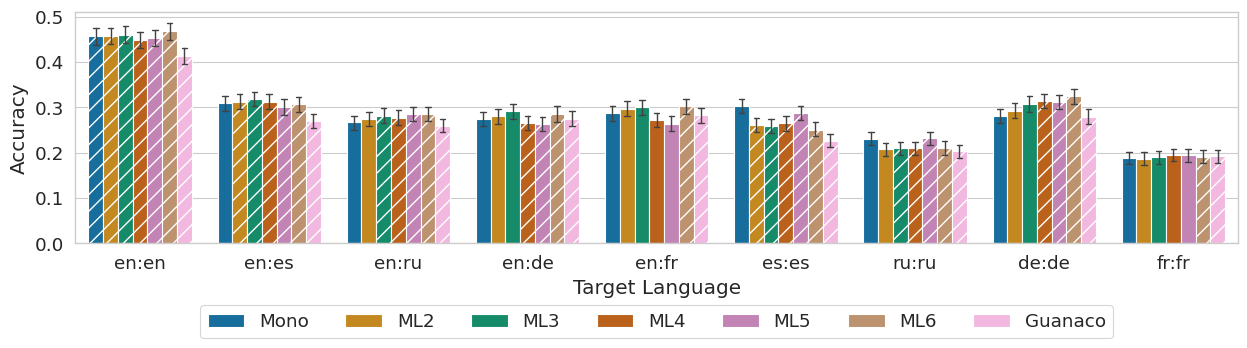

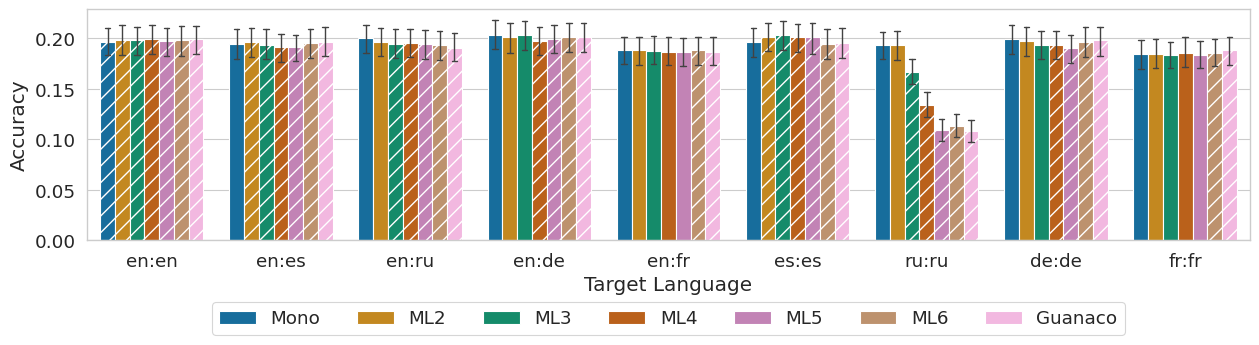

In [91]:
# plot score distribution
def plot_xcsqa_score_distribution(df, title=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(15, 3))
    
    test_sets = [l for l in ordered_xcsr_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    print(test_sets)
    print(model_names)
    # sns.boxplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    # sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    sns.barplot(data=df, x='test_set', y='score', hue='model_name', ax=ax,  
                errorbar=('ci', 95), capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                )
        
    # apply hatches to certain bars
    # for p in ax.patches:
    #     print(p)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
    #         # The index of the bar in the patches list
            index = i * len(model_names) + j
            bar_info[sorted_bars[index]] = {'test_set': test_set.split(':')[-1][:2], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch('//')
        else:
            bar.set_hatch('')
    
    ax.set_xlabel('Target Language')
    ax.set_ylabel('Accuracy')
    
    ax.set_title(title)

    # legend at bottom
    if len(test_sets) >= 6:
        ncols = len(model_names)
        y_offset = -0.45
    else:
        ncols = 3
        y_offset = -0.55
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return


# sdf = df[df['model_name'].isin(['Llama-2 ML6/de', 'Llama-2 ML6/es', 'Llama-2 ML6/ru', 'Llama-2 ML6/fr'])]
# print(sdf['test_set'].value_counts())
# sdf = sdf[sdf['test_set'].isin(ordered_xcsr_test_sets)]
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')

# plot_xcsqa_score_distribution(
#     sdf, 
#     # title='Llama-7b X-CSQA',
#     save_path='data/plots/xcsqa_llama_7b_loo.png'
#     )

sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 ML2', 'Llama-2 ML3', 'Llama-2 ML4', 'Llama-2 ML5', 'Llama-2 ML6/ca', 'Llama-2 Guanaco'])]
print(sdf['test_set'].value_counts())
sdf = sdf[sdf['test_set'].isin(ordered_xcsr_test_sets)]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '').str.strip()

plot_xcsqa_score_distribution(
    sdf, 
    # title='Llama-7b X-CSQA',
    save_path='data/plots/xcsqa_llama_7b_incremental.png'
    )

sdf = df[df['model_name'].isin(['Falcon Mono', 'Falcon ML2', 'Falcon ML3', 'Falcon ML4', 'Falcon ML5', 'Falcon ML6/ca', 'Falcon Guanaco'])]
print(sdf['test_set'].value_counts())
sdf = sdf[sdf['test_set'].isin(ordered_xcsr_test_sets)]
sdf['model_name'] = sdf['model_name'].str.replace('Falcon', '').str.replace('/ca', '').str.strip()

plot_xcsqa_score_distribution(
    sdf, 
    # title='Falcon-7b X-CSQA',
    save_path='data/plots/xcsqa_falcon_7b_incremental.png'
    )

In [92]:
df[df['model_name'] == 'Falcon Mono']

,model_name,test_set,seed,prompt,system,finish_reason,source,secs,reference,score
324000,Falcon Mono,en:en,0,en,"A"" is the most suitable answer. The question asks about traumatic mouth injury, which is a type of injury that can occur in a variety of settings, including town, hospital, office building, and schools. Therefore, ""A"" is the most appropriate answer because it is the most general and inclusive option.\n\nThe other options are too specific and do not cover all possible settings where traumatic mouth injury could occur. ""B"" refers to a town in Michigan, which is not a general or inclusive answer. ""C"" refers to a hospital, which is also too specific and does not cover all possible settings where traumatic mouth injury could occur. ""D"" refers to a school, which is also too specific and does not cover all possible settings where traumatic mouth injury could occur. ""E"" refers to an office building, which is also too specific and does not cover all possible settings where traumatic mouth injury could occur.",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nThe dental office handled a lot of patients who experienced traumatic mouth injury, where were these patients coming from?\n\nOptions:\n\nA: town\nB: michigan\nC: hospital\nD: schools\nE: office building\n\n### Assistant: """,0.130371,"[C, hospital]",0
324001,Falcon Mono,en:en,0,en,"A"" is the correct answer.\n\nBald eagles are found in the midwest, specifically in Colorado, Iowa, and Wisconsin.\n\nC is incorrect because currency is not found in the midwest.\n\nD is incorrect because iowa is not in the midwest.\n\nE is incorrect because wisconsin is not in the midwest.",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nWhere can you find bald eagles and cheese in the midwest?\n\nOptions:\n\nA: colorado\nB: currency\nC: iowa\nD: arctic\nE: wisconsin\n\n### Assistant: """,0.130371,"[E, wisconsin]",0
324002,Falcon Mono,en:en,0,en,"A"" is the most suitable answer because a person may stay at their job without being paid because they enjoy working. This is based on commonsense knowledge and the fact that a person may enjoy working at their job.\n\nThe other options are not suitable because they do not explain why a person would stay at their job without being paid.",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nWhy would a person stay at their job without being paid?\n\nOptions:\n\nA: thank god\nB: wait in line\nC: volunteer\nD: offer help\nE: enjoy working\n\n### Assistant: """,0.130371,"[E, enjoy working]",0
324003,Falcon Mono,en:en,0,en,"A"" is the most suitable answer. The electric fan had gotten too loud and was bothering others, though they allowed many personal things on desks he was required to turn it off where?\n\nThe electric fan had gotten too loud and was bothering others, though they allowed many personal things on desks he was required to turn it off where?\n\nThe electric fan had gotten too loud and was bothering others, though they allowed many personal things on desks he was required to turn it off where?\n\nThe electric fan had gotten too loud and was bothering others, though they allowed many personal things on desks he was required to turn it off where?\n\nThe electric fan had gotten too loud and was bothering oth

In [93]:
# XQuAD
import re

def postprocess_system_response(system, source):
    """
    Strip away trailing text after the first closing quotation mark
    """

    # special handling for de and ru: extract question from source
    question_string = re.search(r"\n\n(Frage|Вопрос):\n\n(.*?)\n\n", source)
    if question_string:
        question_string = question_string.group(2)
        # if question is in system response, remove it
        if system.startswith(question_string):
            text = system[len(question_string):]
            # split text on first full stop or line break
            text = re.split(r'[\.\n]', text)[0].strip()[:50]
            return text

    match = re.match(r'(.*?)["”“»]', system)
    if match:
        text = match.group(1)
        text = re.split(r'[\.\n]', text)[0].strip()[:50]
    else:
        text = ''

    return text

def compute_xquad_score(text, reference):
    """
    Check whether the text answer matches the reference answer
    """

    # normalize punctuation
    reference = reference.replace('’', "'").replace('‘', "'").replace('”', '"').replace('“', '"').replace('«', '"').replace('»', '"').replace('–', '-').replace('—', '-').replace('…', '...')

    if reference == text:
        return 1
    elif reference in text:
        return 1
    else:
        return 0

def get_xquad_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for output_file in sorted(Path(results_dir).glob('*/*.jsonl')):
        df = pd.read_json(output_file, lines=True)
        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(output_file)
        
        df['model_name'] = model_name
        df['test_set'] = test_set

        if prompt == 'blank':
            dataset, split, prompt_lang, tgt_lang = test_set.split('_')
            if prompt_lang == 'en':
                prompt = 'en'
            else:
                prompt = 'X'
                
        df['prompt'] = prompt
        df['seed'] = seed

        dfs.append(df)
            
    df = pd.concat(dfs, axis=0, ignore_index=False, join='outer').reset_index(drop=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('prompt')))
    
    df = df.reindex(columns=cols)

    return df

df = get_xquad_results('data/xquad_outputs/')

# rename values according to name_map
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

df = apply_sort(df, ordered_test_sets=ordered_xquad_test_sets)

print(df['test_set'].value_counts())
print(df['model_name'].value_counts())

df['system'] = df.apply(lambda x: postprocess_system_response(x['system'], x['source']), axis=1)

# drop 'source' column
df = df.drop(columns=['source'])

df['score'] = df.apply(lambda x: compute_xquad_score(x['system'].lower(), x['reference'].lower()), axis=1)


print(df['score'].value_counts())
df.head(30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207684 entries, 0 to 1207683
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   model_name     1207684 non-null  object 
 1   test_set       1207684 non-null  object 
 2   seed           1207684 non-null  int64  
 3   prompt         1207684 non-null  object 
 4   system         1207684 non-null  object 
 5   finish_reason  1207684 non-null  object 
 6   source         1207684 non-null  object 
 7   secs           1207684 non-null  float64
 8   reference      1207684 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 82.9+ MB
en:en     78540
en:es     78540
en:ru     78540
en:de     78540
en:zh     78540
zh:zh     78540
de:de     78540
ru:ru     78540
es:es     78540
th:th*    51170
en:vi*    49980
en:ar*    49980
en:el*    49980
el:el*    49980
ar:ar*    49980
tr:tr*    49980
vi:vi*    49980
en:th*    49980
en:tr*    49814
Name: test_set,

,model_name,test_set,seed,prompt,system,finish_reason,secs,reference,score
0,Llama-2 Mono,en:en,0,en,308 points,stop,0.167729,308,1
1,Llama-2 Mono,en:en,0,en,136,stop,0.167729,136,1
2,Llama-2 Mono,en:en,0,en,118,stop,0.167729,118,1
3,Llama-2 Mono,en:en,0,en,four interceptions,stop,0.167729,four,1
4,Llama-2 Mono,en:en,0,en,Kawann Short,stop,0.167729,Kawann Short,1
5,Llama-2 Mono,en:en,0,en,24,stop,0.167729,24,1
6,Llama-2 Mono,en:en,0,en,Kawann Short,stop,0.167729,Kawann Short,1
7,Llama-2 Mono,en:en,0,en,four,stop,0.167729,four,1
8,Llama-2 Mono,en:en,0,en,four forced fumbles,stop,0.167729,four,1
9,Llama-2 Mono,en:en,0,en,Josh Norman,stop,0.167729,Kurt Coleman,0


th:th*    26180
es:es     24990
vi:vi*    24990
tr:tr*    24990
ar:ar*    24990
el:el*    24990
zh:zh     24990
de:de     24990
ru:ru     24990
en:en     24990
en:es     24990
en:vi*    24990
en:tr*    24990
en:ar*    24990
en:el*    24990
en:zh     24990
en:de     24990
en:ru     24990
en:th*    24990
Name: test_set, dtype: int64
['en:en', 'en:es', 'en:ru', 'en:de', 'en:zh', 'en:el*', 'en:ar*', 'en:tr*', 'en:vi*', 'en:th*', 'es:es', 'ru:ru', 'de:de', 'zh:zh', 'el:el*', 'ar:ar*', 'tr:tr*', 'vi:vi*', 'th:th*']
['Mono' 'ML2' 'ML3' 'ML4' 'ML5' 'ML6' 'Guanaco']
saved to data/plots/xquad_llama_7b_incremental.png


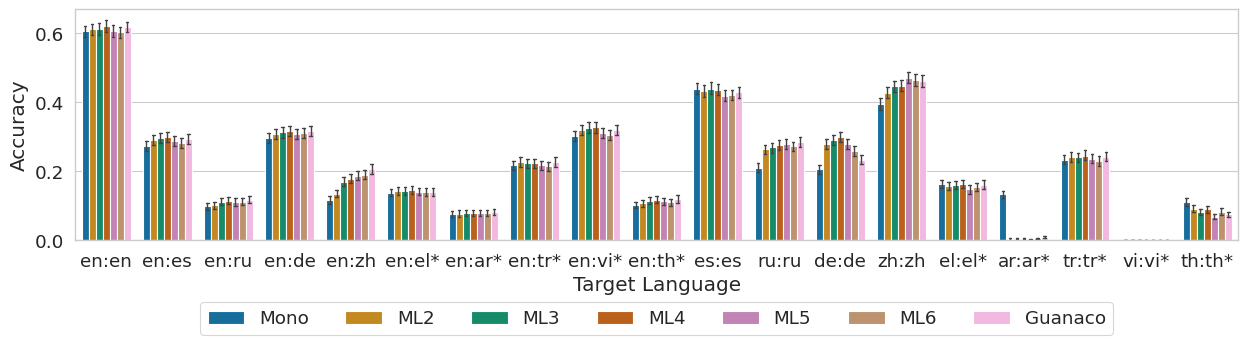

In [94]:
# plot score distribution
def plot_xquad_score_distribution(df, title=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(15, 3))
    
    test_sets = [l for l in ordered_xquad_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    print(test_sets)
    print(model_names)
    # sns.boxplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    # sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    sns.barplot(data=df, x='test_set', y='score', hue='model_name', ax=ax,  
                errorbar=('ci', 95), capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                )
        
    # # apply hatches to certain bars
    # # for p in ax.patches:
    # #     print(p)

    # # remove bars from sorted that correspond to the legend
    # bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    # sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
    # # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    # bar_info = {}
    # for i, test_set in enumerate(test_sets):
    #     for j, model_name in enumerate(model_names):
    # #         # The index of the bar in the patches list
    #         index = i * len(model_names) + j
    #         bar_info[sorted_bars[index]] = {'test_set': test_set.split(':')[-1][:2], 'model_name': model_name}

    # # Loop over the bars and add a text label as a marker
    # for i, (bar, info) in enumerate(bar_info.items()):
    #     if info['test_set'] in training_langs[info['model_name'].split()[-1]]:
    #         bar.set_hatch('//')
    #     else:
    #         bar.set_hatch('')
    
    ax.set_xlabel('Target Language')
    ax.set_ylabel('Accuracy')
    
    ax.set_title(title)

    # legend at bottom
    if len(test_sets) >= 6:
        ncols = len(model_names)
        y_offset = -0.45
    else:
        ncols = 3
        y_offset = -0.55
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return

# sdf = df[df['model_name'].isin(['Llama-2 ML6/de', 'Llama-2 ML6/es', 'Llama-2 ML6/ru', 'Llama-2 ML6/zh'])]
# print(sdf['test_set'].value_counts())
# sdf = sdf[sdf['test_set'].isin(ordered_xquad_test_sets)]
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')

# plot_xquad_score_distribution(
#     sdf, 
#     # title='Llama-7b X-QuAD',
#     save_path='data/plots/xquad_llama_7b_loo.png'
#     )

sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 ML2', 'Llama-2 ML3', 'Llama-2 ML4', 'Llama-2 ML5', 'Llama-2 ML6/ca', 'Llama-2 Guanaco'])]
print(sdf['test_set'].value_counts())
sdf = sdf[sdf['test_set'].isin(ordered_xquad_test_sets)]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '').str.strip()

plot_xquad_score_distribution(
    sdf, 
    # title='Llama-7b X-QuAD',
    save_path='data/plots/xquad_llama_7b_incremental.png'
    )

en:en     24990
es:es     24990
vi:vi*    24990
tr:tr*    24990
ar:ar*    24990
el:el*    24990
zh:zh     24990
de:de     24990
ru:ru     24990
en:th*    24990
en:es     24990
en:vi*    24990
en:ar*    24990
en:el*    24990
en:zh     24990
en:de     24990
en:ru     24990
th:th*    24990
en:tr*    24824
Name: test_set, dtype: int64
['en:en', 'en:es', 'en:ru', 'en:de', 'en:zh', 'en:el*', 'en:ar*', 'en:tr*', 'en:vi*', 'en:th*', 'es:es', 'ru:ru', 'de:de', 'zh:zh', 'el:el*', 'ar:ar*', 'tr:tr*', 'vi:vi*', 'th:th*']
['Mono' 'ML2' 'ML3' 'ML4' 'ML5' 'ML6' 'Guanaco']
saved to data/plots/xquad_falcon_7b_incremental.png


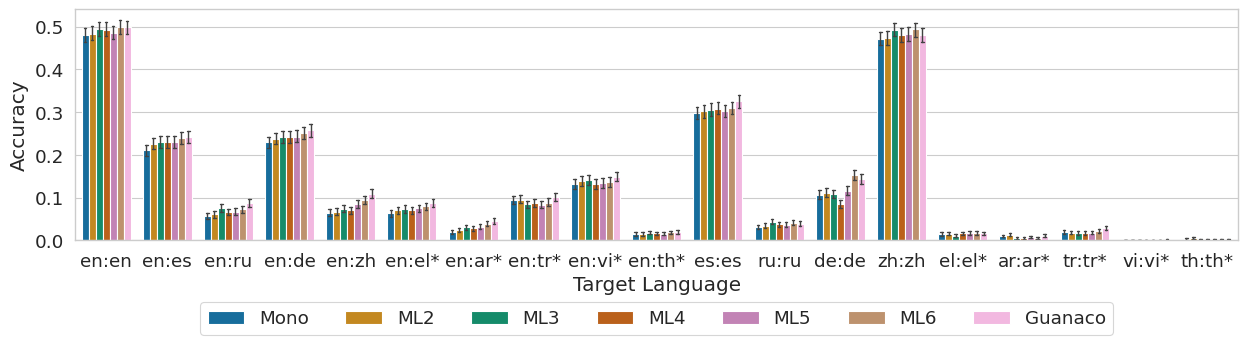

In [95]:
sdf = df[df['model_name'].isin(['Falcon Mono', 'Falcon ML2', 'Falcon ML3', 'Falcon ML4', 'Falcon ML5', 'Falcon ML6/ca', 'Falcon Guanaco'])]
print(sdf['test_set'].value_counts())
sdf = sdf[sdf['test_set'].isin(ordered_xquad_test_sets)]
sdf['model_name'] = sdf['model_name'].str.replace('Falcon ', '').str.replace('/ca', '').str.strip()

plot_xquad_score_distribution(
    sdf, 
    # title='Llama-7b X-QuAD',
    save_path='data/plots/xquad_falcon_7b_incremental.png'
    )

In [100]:
df[df['test_set'] == 'en:tr*']

,model_name,test_set,seed,prompt,system,finish_reason,secs,reference,score
24990,Llama-2 Mono,en:tr*,0,en,308,stop,0.206261,308,1
24991,Llama-2 Mono,en:tr*,0,en,136,stop,0.206261,136,1
24992,Llama-2 Mono,en:tr*,0,en,4,stop,0.206261,118,0
24993,Llama-2 Mono,en:tr*,0,en,Josh Norman had 4 sacks in the 2015 season,stop,0.206261,dört,0
24994,Llama-2 Mono,en:tr*,0,en,Kawann Short,stop,0.206261,Kawann Short,1
...,...,...,...,...,...,...,...,...,...
1168409,Falcon Guanaco,en:tr*,723,en,Electrostatic and magnetic fields are two types of,stop,0.816250,elektrostatik kuvvetin,0
1168410,Falcon Guanaco,en:tr*,723,en,The reason why the deformation of the kuvvetler is,stop,0.816250,Gerilme tensörü,0
1168411,Falcon Guanaco,en:tr*,723,en,"No, the deformation of the kuvertler is not necess",stop,0.816250,basınç terimlerini,0
1168412,Falcon Guanaco,en:tr*,723,en,"No, normal kuvvetlerle ne ilişkilendirilir",stop,0.816250,basınç terimlerini,0


In [238]:
# get length of longest reference
df['reference_len'] = df.apply(lambda x: len(x['reference']), axis=1)
df['reference_len'].describe()

count    1.003312e+06
mean     1.837790e+01
std      1.967557e+01
min      1.000000e+00
25%      6.000000e+00
50%      1.300000e+01
75%      2.200000e+01
max      2.060000e+02
Name: reference_len, dtype: float64

In [239]:
df[df['reference_len'] == 206]

,model_name,test_set,seed,prompt,system,finish_reason,secs,reference,score,reference_len
4099,Llama-2 Mono,en:es,0,en,conexiones de terminal a servidor,stop,0.226155,"se estableció una conexión interactiva de servidor a servidor entre los sistemas informáticos de ordenador central de IBM de la Universidad de Michigan, en Ann Arbor, y de la Universidad del Estado de Wayne",0,206
5289,Llama-2 Mono,en:es,42,en,conexiones de terminal a servidor,stop,0.227885,"se estableció una conexión interactiva de servidor a servidor entre los sistemas informáticos de ordenador central de IBM de la Universidad de Michigan, en Ann Arbor, y de la Universidad del Estado de Wayne",0,206
6479,Llama-2 Mono,en:es,723,en,conexiones de terminal a servidor,stop,0.226429,"se estableció una conexión interactiva de servidor a servidor entre los sistemas informáticos de ordenador central de IBM de la Universidad de Michigan, en Ann Arbor, y de la Universidad del Estado de Wayne",0,206
36229,Llama-2 Mono,es:es,0,X,conexiones de terminal a servidor,stop,0.433165,"se estableció una conexión interactiva de servidor a servidor entre los sistemas informáticos de ordenador central de IBM de la Universidad de Michigan, en Ann Arbor, y de la Universidad del Estado de Wayne",0,206
37419,Llama-2 Mono,es:es,42,X,conexiones de terminal a servidor,stop,0.414958,"se estableció una conexión interactiva de servidor a servidor entre los sistemas informáticos de ordenador central de IBM de la Universidad de Michigan, en Ann Arbor, y de la Universidad del Estado de Wayne",0,206
...,...,...,...,...,...,...,...,...,...,...
976471,Falcon Guanaco,en:es,42,en,"Merit Network, Inc",stop,0.231079,"se estableció una conexión interactiva de servidor a servidor entre los sistemas informáticos de ordenador central de IBM de la Universidad de Michigan, en Ann Arbor, y de la Universidad del Estado de Wayne",0,206
977661,Falcon Guanaco,en:es,723,en,"Merit Network, Inc",stop,0.231427,"se estableció una conexión interactiva de servidor a servidor entre los sistemas informáticos de ordenador central de IBM de la Universidad de Michigan, en Ann Arbor, y de la Universidad del Estado de Wayne",0,206
989561,Falcon Guanaco,es:es,0,X,La tríada completó la red de ordenadores entre tre,stop,0.350729,"se estableció una conexión interactiva de servidor a servidor entre los sistemas informáticos de ordenador central de IBM de la Universidad de Michigan, en Ann Arbor, y de la Universidad del Estado de Wayne",0,206
990751,Falcon Guanaco,es:es,42,X,La tríada completó la red de ordenadores entre tre,stop,0.357431,"se estableció una conexión interactiva de servidor a servidor entre los sistemas informáticos de ordenador central de IBM de la Universidad de Michigan, en Ann Arbor, y de la Universidad del Estado de Wayne",0,206


In [142]:
# def plot_grouped_bars(df, group_column):
#     """
#     Takes a pandas dataframe and a column name as the grouping variable.
#     Initialises a matplotlib figure and axis object and plots data as bar plots.
    
#     Args:
#     df (pd.DataFrame): The pandas dataframe containing the data.
#     group_column (str): The column name to group the data by.
    
#     Returns:
#     matplotlib figure and axis with the bar plot.
#     """
    
#     # Initialize the matplotlib figure and axis object
#     fig, ax = plt.subplots()
    
#     # Unique categories in the grouping variable
#     test_sets = [name for name in ordered_test_sets if name in df['test_set'].unique()]
#     models = test_set_data['model_name'].unique()

#     # expected number of bars
#     expected_num_bars = len(test_sets) * len(models)

#     x_ticks = np.arange(len(expected_num_bars))  # the label locations
#     print(x_ticks)

#     width = 0.1  # the width of the bars
#     multiplier = 0

#     for i, test_set in enumerate(test_sets):
#         # print(i, test_set)
#         # Filter the dataframe for the current category
#         test_set_data = df[df['test_set'] == test_set]

#         models = test_set_data['model_name'].unique()

#         for j, model in enumerate(models):
            
#             model_data = test_set_data[test_set_data['model_name'] == model]
            
#             scores_translated = model_data[ (model_data['eval_src'] == 'source_en') & (model_data['eval_tgt'] == 'system_en') ]['eval_score']
#             scores_untranslated = model_data[ (model_data['eval_src'] == 'source') & (model_data['eval_tgt'] == 'system') ]['eval_score']
    
#             # get average score for each model
#             scores_translated_mean = scores_translated.mean()
#             scores_untranslated_mean = scores_untranslated.mean()

#             # get standard error for each model
#             scores_translated_std = scores_translated.std()
#             scores_untranslated_std = scores_untranslated.std()

#             print(scores_translated_mean, scores_translated_std)
#             print(scores_untranslated_mean, scores_untranslated_std)
            
            
#             # plot translated scores and untranslated scores side by side
#             ax.bar(x_pos, scores_translated_mean, yerr=scores_translated_std, width=width, label=f'{model} tr', hatch='//')
#             # ax.bar(x_ticks[i] + width * multiplier + width, scores_untranslated_mean, yerr=scores_untranslated_std, width=width, label=model, hatch='')

#             multiplier += 1

#             # offset = width * multiplier
#             # print((x + offset))

#             # score_translated = ax.bar((x + offset), [scores_translated_mean], yerr=[scores_translated_std], width=width/0.5, label=model, hatch='//')
#             # print((x + offset))
#             # scores_untranslated = ax.bar((x + offset)+width/0.5, [scores_untranslated_mean], yerr=[scores_untranslated_std], width=width/0.5, label=model, hatch='')
#             # multiplier += 1
#             # ax.bar([test_set]+offset, [scores_translated_mean], yerr=[scores_translated_std], label=model, hatch='//')
#             # ax.bar([test_set]+offset, [scores_untranslated_mean], yerr=[scores_untranslated_std], label=model, hatch='')
#             # offset += 0.2
#             # ax.bar(x=model, height=scores_translated_mean, yerr=scores_translated_std, label='translated', alpha=0.5)
#         #         # The next bar plot should start on top of the previous one, so we update 'bottom'
#         # if bottom is None:
#         #     bottom = summary_data
#         # else:
#         #     bottom = bottom + summary_data
    
#     # set xtick labels as test sets
#     ax.set_xticks(x_ticks)
#     ax.set_xticklabels(test_sets)

#     # Add legend, labels and title
#     ax.legend(title=group_column)
#     ax.set_ylabel("Values")
#     ax.set_title("Grouped Bar Plot")
    
#     # place legend outside of plot at bottom with 3 columns
#     ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3)
    
#     return fig, ax

# plot_grouped_bars(df[df['test_set'].isin(['en','de'])], 'test_set') 

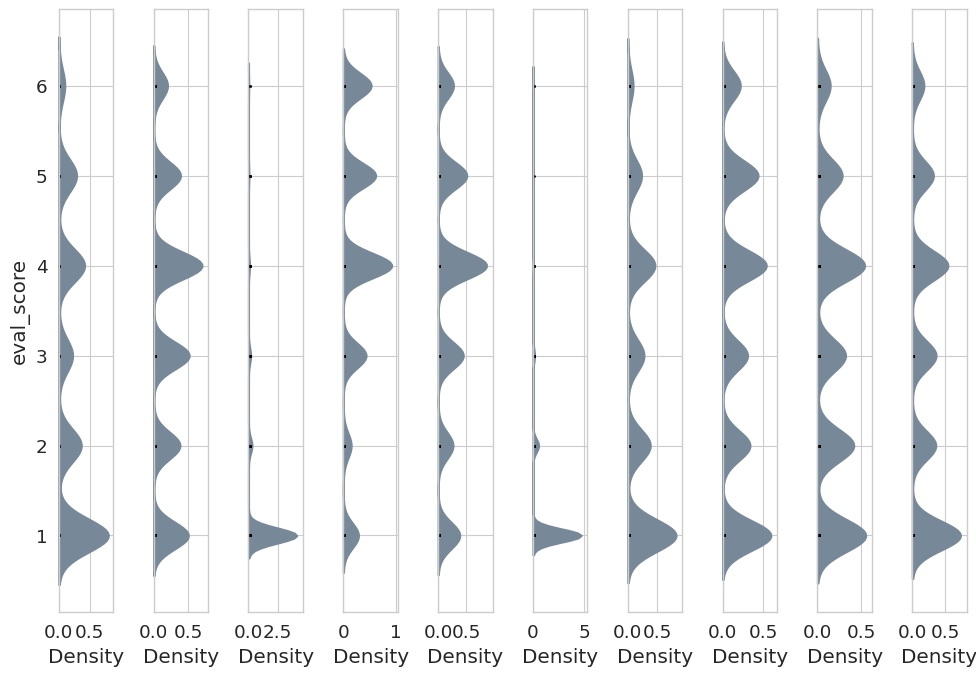

In [22]:
# https://stackoverflow.com/a/67091404/4649965

# def categorical_kde_plot(
#     df,
#     variable,
#     category,
#     category_order=None,
#     horizontal=False,
#     rug=True,
#     figsize=None,
# ):
#     """Draw a categorical KDE plot

#     Parameters
#     ----------
#     df: pd.DataFrame
#         The data to plot
#     variable: str
#         The column in the `df` to plot (continuous variable)
#     category: str
#         The column in the `df` to use for grouping (categorical variable)
#     horizontal: bool
#         If True, draw density plots horizontally. Otherwise, draw them
#         vertically.
#     rug: bool
#         If True, add also a sns.rugplot.
#     figsize: tuple or None
#         If None, use default figsize of (7, 1*len(categories))
#         If tuple, use that figsize. Given to plt.subplots as an argument.
#     """
#     if category_order is None:
#         categories = list(df[category].unique())
#     else:
#         categories = category_order[:]

#     figsize = (7, 1.0 * len(categories))

#     fig, axes = plt.subplots(
#         nrows=len(categories) if horizontal else 1,
#         ncols=1 if horizontal else len(categories),
#         figsize=figsize[::-1] if not horizontal else figsize,
#         sharex=horizontal,
#         sharey=not horizontal,
#     )

#     for i, (cat, ax) in enumerate(zip(categories, axes)):
#         sns.kdeplot(
#             data=df[df[category] == cat],
#             x=variable if horizontal else None,
#             y=None if horizontal else variable,
#             # kde kwargs
#             bw_adjust=0.5,
#             clip_on=False,
#             fill=True,
#             alpha=1,
#             linewidth=1.5,
#             ax=ax,
#             color="lightslategray",
#         )

#         keep_variable_axis = (i == len(fig.axes) - 1) if horizontal else (i == 0)

#         if rug:
#             sns.rugplot(
#                 data=df[df[category] == cat],
#                 x=variable if horizontal else None,
#                 y=None if horizontal else variable,
#                 ax=ax,
#                 color="black",
#                 height=0.025 if keep_variable_axis else 0.04,
#             )

#         # _format_axis(
#         #     ax,
#         #     cat,
#         #     horizontal,
#         #     keep_variable_axis=keep_variable_axis,
#         # )

#     plt.tight_layout()
#     plt.show()


# def _format_axis(ax, category, horizontal=False, keep_variable_axis=True):

#     # Remove the axis lines
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)

#     if horizontal:
#         ax.set_ylabel(None)
#         lim = ax.get_ylim()
#         ax.set_yticks([(lim[0] + lim[1]) / 2])
#         ax.set_yticklabels([category])
#         if not keep_variable_axis:
#             ax.get_xaxis().set_visible(False)
#             ax.spines["bottom"].set_visible(False)
#     else:
#         ax.set_xlabel(None)
#         lim = ax.get_xlim()
#         ax.set_xticks([(lim[0] + lim[1]) / 2])
#         ax.set_xticklabels([category])
#         if not keep_variable_axis:
#             ax.get_yaxis().set_visible(False)
#             ax.spines["left"].set_visible(False)


# # test_df = sns.load_dataset("tips")
# # test_df
# # categorical_kde_plot(
# #     test_df,
# #     variable="tip",
# #     category="day",
# #     category_order=["Thur", "Fri", "Sat", "Sun"],
# #     horizontal=False,
# # )

# categorical_kde_plot(
#     df,
#     variable="eval_score",
#     category="test_set",
#     # category_order=["Thur", "Fri", "Sat", "Sun"],
#     horizontal=False,
# )

In [82]:
def get_generations(results_dir):
    dfs = []
    for generations_file in Path(results_dir).glob('*/*.llm_eval'):
        # print(eval_file)
        df = pd.read_json(generations_file, lines=True)
        model_name, test_set, prompt, seed = parse_filename(generations_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
    df = pd.concat(dfs, axis=0, ignore_index=False)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    # cols.insert(0, df.ndex)
    df = df.reindex(columns=cols)

    return df

gen_df = get_generations(results_dir)

gen_df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)
print(len(gen_df))
print(gen_df.columns)
gen_df.head()

# data/outputs/llama_2_7b_hf_zh_merged/alpaca_eval_instructions_zh-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8-gpt_3.5_turbo-l50.llm_eval

3750
Index(['model_name', 'test_set', 'seed', 'prompt', 'system', 'finish_reason',
       'source', 'secs', 'source_lang', 'system_lang', 'id',
       'gpt-3.5-turbo-judgement', 'gpt-3.5-turbo-justification',
       'gpt-3.5-turbo-cost', 'context', 'gpt-4-judgement',
       'gpt-4-justification', 'gpt-4-cost'],
      dtype='object')


,model_name,test_set,seed,prompt,system,finish_reason,source,secs,source_lang,system_lang,id,gpt-3.5-turbo-judgement,gpt-3.5-turbo-justification,gpt-3.5-turbo-cost,context,gpt-4-judgement,gpt-4-justification,gpt-4-cost
0,Llama-2 ML6/de,de,42,"### Human: ""Warum fühlt man sich durch Wärme m...",Die Frage nach dem Verständnis der psychologis...,stop,"""Warum fühlt man sich durch Wärme müde?""",1.623084,deu_Latn,deu_Latn,193,Excellent,"informative, interesting",0.001520,guanaco_prompt,NaN,NaN,NaN
1,Llama-2 ML6/de,de,42,"### Human: ""Erklären Sie, was das unterstriche...","Für Kinder ist das unterstrichene Wort ""ein Ve...",stop,"""Erklären Sie, was das unterstrichene Wort für...",0.935782,deu_Latn,deu_Latn,719,Excellent,"informative, interesting",0.001094,guanaco_prompt,NaN,NaN,NaN
2,Llama-2 ML6/de,de,42,"### Human: ""Eins Eins war ein Rennpferd. Zwei ...","In dieser Geschichte gibt es zwei Pferde, ein ...",stop,"""Eins Eins war ein Rennpferd. Zwei Zwei war au...",1.396412,deu_Latn,deu_Latn,169,Excellent,"informative, interesting",0.000906,guanaco_prompt,NaN,NaN,NaN
3,Llama-2 ML6/de,de,42,"### Human: ""Dir wird eine Beschreibung gegeben...",Als Reaktion auf die geplante russische Invasi...,stop,"""Dir wird eine Beschreibung gegeben, die eine ...",1.525187,deu_Latn,deu_Latn,523,Fail,language,0.001013,guanaco_prompt,NaN,NaN,NaN
4,Llama-2 ML6/de,de,42,"### Human: ""Dir wird ein Thema für einen Insta...","""Beitrag zum Instagram-Beitrag über Frauen in ...",stop,"""Dir wird ein Thema für einen Instagram-Beitra...",1.177709,deu_Latn,deu_Latn,537,Excellent,"informative, interesting",0.000775,guanaco_prompt,NaN,NaN,NaN


In [83]:
gen_df['model_name_test_set'] = gen_df['model_name'] + ' ' + gen_df['test_set']

fig_width: 6, fig_height: 4.0, subplot_height: 0.16666666666666666
ML6/zh zh: {'Excellent': 24.0, 'Pass': 21.333333333333336, 'Fail': 54.666666666666664}
ML6/zh ru: {'Excellent': 17.333333333333336, 'Pass': 14.666666666666666, 'Fail': 68.0}
ML6/zh is: {'Excellent': 1.3333333333333335, 'Pass': 15.333333333333332, 'Fail': 83.33333333333334}
ML6/zh hi: {'Excellent': 9.333333333333334, 'Pass': 22.666666666666664, 'Fail': 68.0}
ML6/zh fr: {'Excellent': 67.33333333333333, 'Pass': 12.0, 'Fail': 20.666666666666668}
ML6/zh en: {'Excellent': 82.66666666666667, 'Pass': 4.666666666666667, 'Fail': 12.666666666666668}
ML6/zh el: {'Excellent': 0.6666666666666667, 'Pass': 11.333333333333332, 'Fail': 88.0}
ML6/zh de: {'Excellent': 70.0, 'Pass': 18.0, 'Fail': 12.0}
ML6/ru zh: {'Excellent': 33.33333333333333, 'Pass': 18.0, 'Fail': 48.66666666666667}
ML6/ru ru: {'Excellent': 14.000000000000002, 'Pass': 11.333333333333332, 'Fail': 74.66666666666667}
ML6/ru is: {'Excellent': 4.666666666666667, 'Pass': 5.333

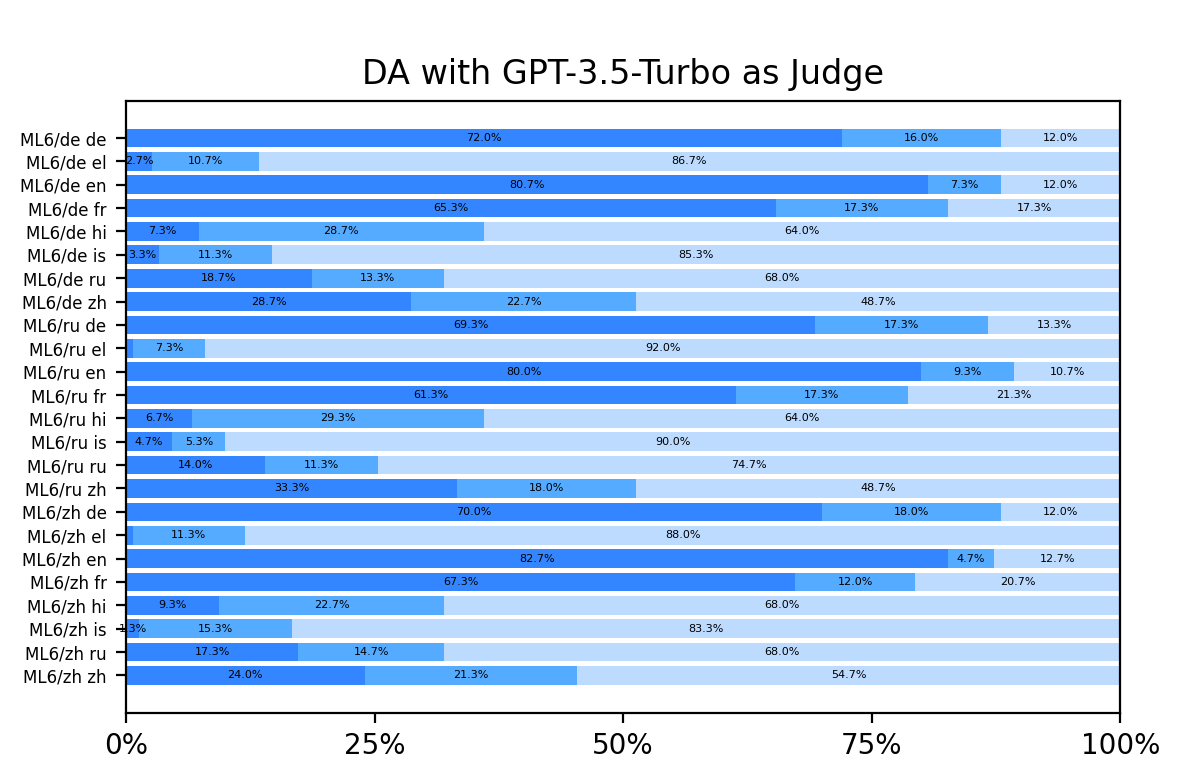

In [ ]:
def calculate_legend_bbox(subplot_height, figsize_height, margin_fraction=0.1):
    # Calculate the margin as a fraction of the subplot height
    margin = margin_fraction * subplot_height

    # Calculate the bbox_to_anchor value
    bbox_to_anchor = (0.5, -margin / figsize_height)

    return bbox_to_anchor

def calculate_figure_height(num_items, target_aspect_ratio):
    # Calculate the width of the figure based on the target aspect ratio
    fig_width = 6
    fig_height = fig_width / target_aspect_ratio

    # Calculate the subplot height based on the number of items
    subplot_height = fig_height / num_items

    return fig_width, fig_height, subplot_height

# plot the judgemtnts for each model
def plot_judgements(df, judge='GPT-3.5-Turbo', title=None, task_id='', output_dir=None, target_aspect_ratio=1.5, margin_fraction=0.5):
    """
    
    """
    
    # models = df['model_name'].unique().tolist()[::-1]
    test_sets = df['model_name_test_set'].unique().tolist()[::-1]

    # Calculate the figure width, height, and subplot height
    fig_width, fig_height, subplot_height = calculate_figure_height(len(test_sets), target_aspect_ratio=target_aspect_ratio)
    print(f'fig_width: {fig_width}, fig_height: {fig_height}, subplot_height: {subplot_height}')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_width, fig_height), sharey=True, sharex=True, dpi=200, tight_layout=True)

    colors = {'Excellent': '#0068FF', 'Pass': '#2B96FF', 'Fail': '#ABD2FF'}

    # for i, model in enumerate(models):
        # print(model)
    for j, test_set in enumerate(test_sets):
        # print(test_set)
        # sdf = df[(df['model_name'] == model) & (df['test_set'] == test_set)]
        sdf = df[df['model_name_test_set'] == test_set]
        # print(len(sdf))
        # print(sdf.columns)
        if judge == 'GPT-3.5-Turbo':
            results = sdf['gpt-3.5-turbo-judgement'].value_counts(normalize=True).to_dict()
        elif judge == 'GPT-4':
            results = sdf['gpt-4-judgement'].value_counts(normalize=True).to_dict()
        else:
            raise ValueError(f'Unknown judge: {judge}')
        
        # sort order: 'Excellent, Pass, Fail'
        results = {k: results.get(k, 0.0) for k in ['Excellent', 'Pass', 'Fail']}
        # multiply by 100 to get percentage
        results = {k: v * 100 for k, v in results.items()}

        print(f'{test_set}: {results}')

        prev_val = 0
        for k, v in results.items():

            ax.barh(y=j, width=v, height=0.8, left=prev_val, 
                    color=colors[k], alpha=0.8, # set the color of each bar individually
                    label=k if j == 0 else "", # label the first bar in each stack with the model name
                    )
            
            # label bar with value
            if v > 1:
                ax.text(x=prev_val + v/2, y=j, s=f'{v:.1f}%', ha='center', va='center', fontsize=4)

            # add the value of each bar to the previous value
            prev_val += v
    
            # # hide legend for all but the first model
            # if i == 0 and j > 0:
            #     ax.get_legend().remove()


    # Set the y-ticks to be the model names
    ax.set_yticks(np.arange(len(test_sets)), test_sets, fontsize=6)
    ax.set_xlabel('')

    ax.set_xticks([0, 25, 50, 75, 100], ['0%', '25%', '50%', '75%', '100%'], minor=False)
    # ax.set_xticklabels()

    # remove x-axis ticks
    # ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
    # # put the legend out of the plot and center it
    # # if len(models) > 2:
    # bbox_to_anchor = calculate_legend_bbox(subplot_height, fig_height, margin_fraction=margin_fraction)
    # print(bbox_to_anchor)
    # ax.legend(bbox_to_anchor=bbox_to_anchor, loc='lower center', ncol=3, frameon=False)# , fontsize=8)
    # # else:
    # #     ax.legend(bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol=3, frameon=False, fontsize=8)

    # Adjust the margins
    plt.margins(y=0.05, x=0.0)

    # title of plot
    if not title:
        ax.set_title(f'{task_id}\nDA with {judge} as Judge')
    else:
        ax.set_title(title)

    if output_dir is not None:
        outfile = Path(output_dir) / f'da_judge_{judge}-{task_id}.png'
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
        print(f'Saved to {outfile}')

    return

plot_judgements(gen_df, judge='GPT-3.5-Turbo')

fig_width: 6, fig_height: 4.0, subplot_height: 0.16666666666666666
ML6/zh zh: {'Excellent': 70.0, 'Pass': 8.0, 'Fail': 22.0}
ML6/zh ru: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh is: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh hi: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh fr: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh en: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh el: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh de: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru zh: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru ru: {'Excellent': 66.0, 'Pass': 6.0, 'Fail': 28.000000000000004}
ML6/ru is: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru hi: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru fr: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru en: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru el: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru de: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/de zh: {'Excell

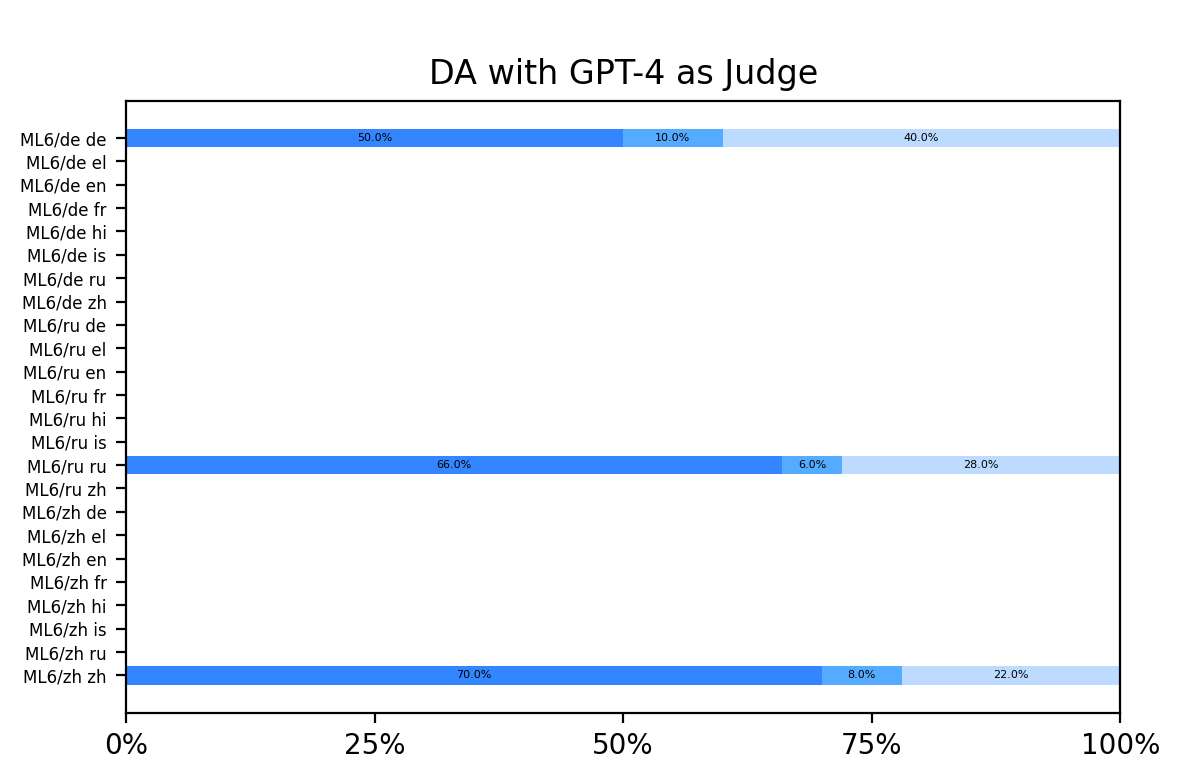

In [62]:
plot_judgements(gen_df, judge='GPT-4')


In [67]:
gen_df['gpt-4-justification'].value_counts()

gpt-4-justification
informative, interesting, correct                                                                                                                                                                                                                                   42
informative, interesting, and correct                                                                                                                                                                                                                               20
incorrect information                                                                                                                                                                                                                                                5
informative, correct, and detailed                                                                                                                                                             

In [68]:
gen_df['gpt-3.5-turbo-justification'].value_counts()

gpt-3.5-turbo-justification
language                                                                                                                                                                                                 1810
informative, interesting                                                                                                                                                                                 1112
grammatical, sufficient                                                                                                                                                                                   263
grammatical, informative                                                                                                                                                                                   92
grammatical                                                                                                                                         

In [14]:
# inspect off-target generations in output files

def get_generations(results_dir):
    dfs = []
    for generations_file in Path(results_dir).glob('*/*.jsonl'):
        # print(eval_file)
        df = pd.read_json(generations_file, lines=True)
        model_name, test_set, prompt, seed = parse_filename(generations_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
    df = pd.concat(dfs, axis=0, ignore_index=False)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    # cols.insert(0, df.ndex)
    df = df.reindex(columns=cols)

    return df

gen_df = get_generations(results_dir)
gen_df

,model_name,test_set,seed,prompt,system,finish_reason,source,secs,source_lang,system_lang,context
0,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Wie lauten die Namen einiger berüh...",Here are some famous actors who began their ca...,stop,"""Wie lauten die Namen einiger berühmter Schaus...",2.562441,deu_Latn,eng_Latn,guanaco_prompt
1,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Wie haben die US-Bundesstaaten ihr...",Die Staaten der Vereinigten Staaten von Amerik...,length,"""Wie haben die US-Bundesstaaten ihre Namen erh...",2.562441,deu_Latn,deu_Latn,guanaco_prompt
2,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Hallo, meine Schwester und ihre Fr...",Sure! Kickball is a game that combines element...,stop,"""Hallo, meine Schwester und ihre Freundinnen m...",2.562441,deu_Latn,eng_Latn,guanaco_prompt
3,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Was sind einige coole Musikstücke ...","""Die 20er Jahre waren eine Zeit des wirtschaft...",stop,"""Was sind einige coole Musikstücke aus den 192...",2.562441,deu_Latn,deu_Latn,guanaco_prompt
4,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Wie verpacke ich ein Geschenk orde...","""Ein Geschenk verpacken ist eine wichtige Sach...",stop,"""Wie verpacke ich ein Geschenk ordentlich?""",2.562441,deu_Latn,deu_Latn,guanaco_prompt
...,...,...,...,...,...,...,...,...,...,...,...
800,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 为一段YouTube视频撰写剧本，探索爵士乐的历史和文化意义。### ...,"[推荐视频]\n\n<iframe width=""560"" height=""315"" src...",stop,为一段YouTube视频撰写剧本，探索爵士乐的历史和文化意义。,3.112936,NaN,NaN,guanaco_prompt
801,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 撰写一篇有趣的旅行博客文章，介绍最近去夏威夷的旅行，重点突出文化体验和...,![](https://cdn-images-1.medium.com/max/1600/1...,stop,撰写一篇有趣的旅行博客文章，介绍最近去夏威夷的旅行，重点突出文化体验和必看景点。,3.112936,NaN,NaN,guanaco_prompt
802,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 为一部最近上映的科幻电影撰写一个引人入胜的影评，讨论其剧情、角色和特效...,电影《黑洞之魂》简介\n\n《黑洞之魂》是一部2021年上映的科幻电影，由迈克尔·杰克逊导演...,stop,为一部最近上映的科幻电影撰写一个引人入胜的影评，讨论其剧情、角色和特效。,3.112936,NaN,NaN,guanaco_prompt
803,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 为一集讨论流媒体平台对音乐产业影响的播客脚本进行构建。### Assi...,[一句话简介]\n\n我们将讨论流媒体平台对音乐产业的影响，并对此进行探讨。我们将从三个角度...,stop,为一集讨论流媒体平台对音乐产业影响的播客脚本进行构建。,3.112936,NaN,NaN,guanaco_prompt


In [15]:
# def inspect_longer_strings(text):
#     # escape newlines
#     text = text.replace('\n', '\\n')
#     text_ = text[:100]
#     if len(text) > len(text_):
#         text_ += '...'
#     return text_

# for i, row in gen_df.iterrows():
#     expected_lang = row['test_set'][-2:]
#     # print(expected_lang)
#     if row['system_lang'] != expected_lang:
#         print(i, inspect_longer_strings(row['source']))
#         print(row['system_lang'], inspect_longer_strings(row['system']))
#         print('*****')
#         # break

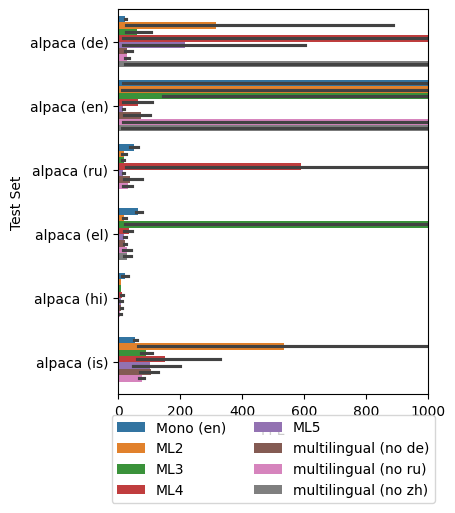

In [16]:
# plot bar plots of lang_match

fig, ax = plt.subplots(figsize=(4, 5))

sns.barplot(x='ppl', y='test_set', hue='model_name', errorbar='ci', orient='h', data=df, ax=ax)

ax.set_xlabel('PPL')
ax.set_ylabel('Target Language')

ax.set_xlim(0, 1000)
# legend at bottom
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)



In [ ]:
# # sort models given the order in name_map
# model_names = df['model_name'].unique()
# ordered_model_names = sorted(model_names, key=lambda x: list(name_map.values()).index(x))
# print(ordered_model_names)
# ordered_test_sets = sorted(df['test_set'].unique())
# print(ordered_test_sets)
# ordered_seeds = sorted(df['seed'].unique())
# print(ordered_seeds)

# def apply_sort(df):

#     df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)

#     df['context'] = pd.Categorical(df['context'], ordered_contexts)

#     df = df.sort_values(by=['test_set', 'model_name', 'context', 'seed'])

#     # Convert the columns back to their original data types
#     df['model_name'] = df['model_name'].astype(str)
#     df['context'] = df['context'].astype(str)
        
#     df = df.reset_index(drop=True)

#     return df

# # drop columns containing any NaN values
# # df = df.dropna(axis=1, how='any')

# # sort dataframe
# df = apply_sort(df)

# # store sort order
# custom_sort_index = df.index.tolist()
# df['idx'] = custom_sort_index
# print(df.columns)
# df.head(4)